In [13]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

In [14]:
#from multiprocesspandas import applyparallel
from joblib import Parallel, delayed
import time
from pandarallel import pandarallel

## 1. Loading Data

### 1.1 RBP targets

In [18]:
## the RBP binding wins in Eclip
rbp_binding_wins = load_large_dataFrame("../Current_Data/07.RBP_targets/clip.allPeak.ENCODE_genome2TransCoords.longestCDS.binding_wins.csv", 
                                        header=[0], index_col=[0,1])
rbp_binding_wins

## PUM2 binding Motifs
rbp_binding_motifs = load_large_dataFrame("../Current_Data/07.RBP_targets/fimo.RBP_motifs_on_ref.rbp.txt", header=[0], index_col=[0,1])
#rbp_binding_motifs

### 1.2. load reac matrix

In [19]:
wide_reac_df_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
wide_reac_df_1nt = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
#wide_reac_df_10nt

### 1.3. load Rsq matrix

In [20]:
long_rsq_df_10nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.10nt.stage.csv",  header=[0], index_col=[0,1])
long_rsq_df_10nt['rsq'] = np.power(long_rsq_df_10nt['r'],2)
wide_rsq_df_10nt = long_rsq_df_10nt.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
#wide_rsq_df_10nt

#long_rsq_df_1nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.1nt.stage.csv",  header=[0], index_col=[0,1])
#long_rsq_df_1nt['rsq'] = np.power(long_rsq_df_1nt['r'],2)
#wide_rsq_df_1nt = long_rsq_df_1nt.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
#wide_rsq_df_1nt

### 1.4. load gene expression of each cell

In [21]:
gene_expr = load_large_dataFrame("../../Gene_Expr/gene_expr.TPM.txt", header=[0,1,2,3,4], index_col=[0])
gene_expr = gene_expr.xs('nai-n3', level="agent", axis=1)
#gene_expr = gene_expr.groupby(level=['stage'], axis=1).mean()
#gene_expr

In [7]:
bulk_expr =  load_large_dataFrame("../../Gene_Expr/gene_expr.bulk.TPM.txt", header=[0,1,2,3,4], index_col=[0])
bulk_expr = bulk_expr.xs("bulk", level="lib_type", axis=1)
bulk_log_expr = pd.DataFrame(np.log10(bulk_expr+1), index=bulk_expr.index, columns=bulk_expr.columns)
bulk_log_expr = bulk_log_expr.stack([0,1,2,3]).to_frame('log10TPM').reset_index().set_index('transcript')
bulk_log_expr

,batch,stage,agent,id,log10TPM
transcript,,,,,
OR4F5,batch_1,day0,dmso,RHE1648,0.000000
OR4F5,batch_1,day0,dmso,RHE1649,0.000000
OR4F5,batch_1,day0,nai-n3,RHE1650,0.000000
OR4F5,batch_1,day0,nai-n3,RHE1651,0.000000
OR4F5,batch_1,day1,dmso,RHE1608,0.000000
...,...,...,...,...,...
human_large,batch_1,day7,nai-n3,RHN1569,4.347271
human_large,batch_1,h9,dmso,RHE1554,3.580145
human_large,batch_1,h9,dmso,RHE1560,3.587692


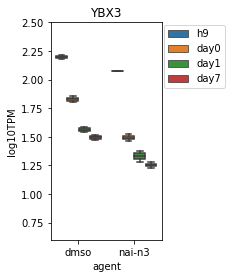

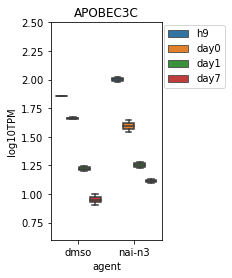

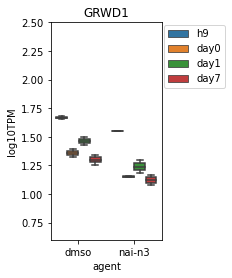

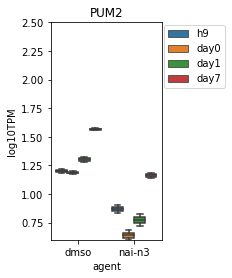

,batch,stage,agent,id,log10TPM
transcript,,,,,
PUM2,batch_1,day0,dmso,RHE1648,1.175006
PUM2,batch_1,day0,dmso,RHE1649,1.197386
PUM2,batch_1,day0,nai-n3,RHE1650,0.684851
PUM2,batch_1,day0,nai-n3,RHE1651,0.595350
PUM2,batch_1,day1,dmso,RHE1608,1.281009
PUM2,batch_1,day1,dmso,RHE1609,1.322360
PUM2,batch_1,day1,nai-n3,RHE1610,0.828876
PUM2,batch_1,day1,nai-n3,RHE1611,0.723689
PUM2,batch_1,day7,dmso,RHN1566,1.575489


In [216]:
for RBP in ['YBX3','APOBEC3C','GRWD1','PUM2']:
    rbp_expr = bulk_log_expr.loc[RBP]
    t = pd.CategoricalDtype(categories=['h9','day0','day1','day7'], ordered=True)
    rbp_expr['stage'] = rbp_expr['stage'].astype(t)
    #rbp_expr = rbp_expr.loc[rbp_expr['agent']=="dmso"]
    fig, ax = plt.subplots(1,1, figsize=(2,4))
    sns.boxplot(data=rbp_expr, hue="stage", y="log10TPM", x="agent")
    plt.ylim(0.6,2.5)
    plt.legend(loc=[1.02, 0.7])
    plt.title(RBP)
    plt.show()
rbp_expr

### 1.5 reac2rsq matrix

In [77]:
wide_avg_reac_df_10nt = wide_reac_df_10nt.groupby(level="stage", axis=1).mean()
wide_h9_reac_df_10nt = wide_avg_reac_df_10nt[['h9']].dropna()
wide_h9_reac_df_10nt = wide_h9_reac_df_10nt.loc[wide_h9_reac_df_10nt.index.get_level_values('gene')!="human_small"]
wide_h9_reac_df_10nt['reac.qtl'] = pd.qcut(wide_h9_reac_df_10nt['h9'], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
wide_h9_reac_df_10nt.columns = ['reac', 'reac.qtl']

wide_rsq_df_10nt
wide_h9_rsq_df_10nt = wide_rsq_df_10nt[['h9']].dropna()
wide_h9_rsq_df_10nt = wide_h9_rsq_df_10nt.loc[wide_h9_rsq_df_10nt.index.get_level_values('gene')!="human_small"]
wide_h9_rsq_df_10nt['rsq.qtl'] = pd.qcut(wide_h9_rsq_df_10nt['h9'], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
wide_h9_rsq_df_10nt.columns = ['rsq', 'rsq.qtl']

wide_h9_reac2rsq = pd.concat([wide_h9_reac_df_10nt, wide_h9_rsq_df_10nt], axis=1, join="inner")
wide_h9_reac2rsq

reac reac.qtl       rsq rsq.qtl
gene  pos                                      
AARS1 3160  0.000760        1  0.056084       2
      3170  0.009422        3  0.350402       3
      3180  0.006138        3  0.514118       4
      3190  0.009888        4  0.718837       4
      3200 -0.008212        1  0.322359       3
...              ...      ...       ...     ...
ZYX   2080 -0.003270        1  0.680677       4
      2090  0.000433        1  0.060489       2
      2100 -0.002050        1  0.275267       3
      2110  0.017561        4  0.172739       2
      2120  0.006327        3  0.000124       1

[55254 rows x 4 columns]

In [110]:
wide_avg_reac_df_1nt = wide_reac_df_1nt.groupby(level="stage", axis=1).mean()
wide_h9_reac_df_1nt = wide_avg_reac_df_1nt[['h9']].dropna()
wide_h9_reac_df_1nt = wide_h9_reac_df_1nt.loc[wide_h9_reac_df_1nt.index.get_level_values('gene')!="human_small"]
wide_h9_reac_df_1nt['reac.qtl'] = pd.qcut(wide_h9_reac_df_1nt['h9'], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
wide_h9_reac_df_1nt.columns = ['reac', 'reac.qtl']

wide_rsq_df_1nt
wide_h9_rsq_df_1nt = wide_rsq_df_1nt[['h9']].dropna()
wide_h9_rsq_df_1nt = wide_h9_rsq_df_1nt.loc[wide_h9_rsq_df_1nt.index.get_level_values('gene')!="human_small"]
wide_h9_rsq_df_1nt['rsq.qtl'] = pd.qcut(wide_h9_rsq_df_1nt['h9'], [0, .25, .5, .75, 1.], labels=[1,2,3,4])
wide_h9_rsq_df_1nt.columns = ['rsq', 'rsq.qtl']

wide_h9_reac2rsq = pd.concat([wide_h9_reac_df_1nt, wide_h9_rsq_df_1nt], axis=1, join="inner")
wide_h9_reac2rsq

reac reac.qtl       rsq rsq.qtl
gene  pos                                      
AARS1 3160  0.009110        3  0.056981       2
      3161  0.001208        2  0.470970       4
      3162 -0.006093        1  0.277138       3
      3163  0.003987        3  0.584183       4
      3164 -0.000846        1  0.404146       3
...              ...      ...       ...     ...
ZYX   2122  0.003546        2  0.361420       3
      2123  0.002824        2  0.136280       2
      2124  0.023745        4  0.174003       2
      2125  0.002188        2  0.084531       2
      2126  0.007732        3  0.094987       2

[557275 rows x 4 columns]

### 1.6 PUM2oe/kd

In [8]:
pum2oe_reac_1nt = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/pum2OE.transcripts.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
pum2kd_reac_1nt = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/pum2KD.transcripts.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])

In [21]:
pum2oe_reac_1nt

id                RHS3513   RHS3514   RHS3515   RHS3519   RHS3520   RHS3521  \
batch                  oe        oe        oe        oe        oe        oe   
stage             control   control   control   control   control   control   
lib_type           single    single    single    single    single    single   
gene       pos                                                                
AC005329.1 922        NaN  0.031250  0.000000  0.000000  0.000000       NaN   
           923        NaN  0.014493  0.011765  0.000000  0.000000       NaN   
           924        NaN  0.047101  0.000895 -0.010870 -0.010870       NaN   
           926        NaN  0.018459  0.033430  0.001974  0.005222       NaN   
           927        NaN  0.004085 -0.009804 -0.009804 -0.009804  0.353832   
...                   ...       ...       ...       ...       ...       ...   
ZYX        2143  0.006814  0.023536       NaN       NaN       NaN  0.048567   
           2144  0.107708 -0.024385       NaN       NaN       NaN -0.021150   
           2145  0.032654  0.046478       NaN       NaN       NaN       NaN   
           2146  0.010416  0.011851       NaN       NaN       NaN       NaN   
           2147 -0.008333  0.012821       NaN       NaN       NaN       NaN   

id                RHS3525   RHS3526   RHS3527   RHS3531  ...   RHS3535  \
batch                  oe        oe        oe        oe  ...        oe   
stage             control   control   control   control  ...      pum2   
lib_type           single    single    single    single  ...    single   
gene       pos                                           ...             
AC005329.1 922        NaN       NaN  0.007194       NaN  ...       NaN   
           923        NaN       NaN  0.000000       NaN  ...       NaN   
           924        NaN       NaN  0.003019       NaN  ...       NaN   
           926        NaN       NaN  0.030014       NaN  ...       NaN   
           927   0.006863       NaN  0.007537       NaN  ...       NaN   
...                   ...       ...       ...       ...  ...       ...   
ZYX        2143 -0.014925 -0.002730       NaN -0.014925  ... -0.016667   
           2144  0.112899 -0.000958       NaN -0.022392  ...  0.068719   
           2145  0.056254  0.004924       NaN  0.008553  ... -0.045113   
           2146  0.014792  0.021788       NaN       NaN  ... -0.048780   
           2147  0.141667 -0.018627       NaN       NaN  ...  0.059364   

id                RHS3536   RHS3540 RHS3541   RHS3546 RHS3547   RHS3552  \
batch                  oe        oe      oe        oe      oe        oe   
stage                pum2      pum2    pum2      pum2    pum2      pum2   
lib_type           single    single  single    single  single    single   
gene       pos                                                            
AC005329.1 922        NaN -0.002941     NaN -0.002941     NaN  0.003681   
           923        NaN  0.002844     NaN  0.019439     NaN  0.020160   
           924        NaN  0.227297     NaN -0.004587     NaN  0.001586   
           926        NaN  0.001762     NaN -0.027223     NaN -0.021163   
           927        NaN  0.002296     NaN -0.025481     NaN -0.008907   
...                   ...       ...     ...       ...     ...       ...   
ZYX        2143 -0.016667 -0.016667     NaN -0.005556     NaN -0.008793   
           2144 -0.020833  0.002976     NaN  0.002155     NaN -0.004573   
           2145 -0.032918 -0.032613     NaN -0.045113     NaN -0.018797   
           2146 -0.024089  0.016155     NaN -0.035960     NaN  0.020526   
           2147 -0.016393  0.036238     NaN  0.009581     NaN  0.003809   

id                RHS3553   RHS3558 RHS3559  
batch                  oe        oe      oe  
stage                pum2      pum2    pum2  
lib_type           single    single  single  
gene       pos                               
AC005329.1 922  -0.002941       NaN     NaN  
           923  -0.012308       NaN     NaN  
           924  -0.004587  

### 1.7 TE data

In [ ]:
te_data = load_large_dataFrame("../../Translation_Effiency/TE_average_replicates.csv")
te_data = te_data.set_index('name')
te_data.index.name = 'gene'
te_data.rename(columns={'H9':'h9','H9D0':'day0','H9D1':'day1','H9D7':'day7'}, inplace=True)
#te_data.to_csv("../Current_Data/08.TE_&_Decay/translation_efficiency.csv")

In [3]:
te_data = load_large_dataFrame("../Current_Data/08.TE_&_Decay/translation_efficiency.csv")
te_data = te_data.reset_index().groupby('gene').mean()
te_data.columns.name = "stage"
te_data.loc[te_data.loc[te_data.index.duplicated()].index]
te_data = te_data.stack().to_frame('te')

### 1.8 Decay data

In [16]:
decay_data = load_large_dataFrame("../../RNA_Decay/diff_halfLife_Noiseq.tsv", index_col=None)
decay_data[['s1','s2']] = decay_data['comp'].str.split("_", expand=True)
decay_data['s1'] = decay_data['s1'].map({'H9':'h9','H9D0':'day0','H9D1':'day1','H9D7':'day7'})
decay_data['s2'] = decay_data['s2'].map({'H9':'h9','H9D0':'day0','H9D1':'day1','H9D7':'day7'})

decay_data_1 = decay_data.loc[decay_data['s1'].isin(['h9','day0','day1'])]
decay_data_2 = decay_data.loc[decay_data['s2'].isin(['day7'])]

decay_data_1 = decay_data_1.pivot(index="gene", columns='s1', values="H9D0_mean")
decay_data_2 = decay_data_2.pivot(index="gene", columns='s2', values="H9D1_mean")

decay_data_new = pd.concat([decay_data_1, decay_data_2], axis=1)
#decay_data_new.to_csv("../Current_Data/08.TE_&_Decay/decay.csv")

In [4]:
decay_data = load_large_dataFrame("../Current_Data/08.TE_&_Decay/decay.csv")
decay_data.columns.name = "stage"
decay_data = decay_data.stack().to_frame('decay')
#decay_data

In [5]:
gene_te_and_decay = pd.concat([te_data, decay_data], axis=1)
gene_te_and_decay = gene_te_and_decay.reset_index().set_index(['gene'])
t = pd.CategoricalDtype(categories=['h9','day0','day1','day7'], ordered=True)
gene_te_and_decay['stage'] = gene_te_and_decay['stage'].astype(t)

gene_delta_te = gene_te_and_decay.reset_index().pivot(index=['gene'], columns='stage', values='te').dropna(how="all")
gene_delta_decay = gene_te_and_decay.reset_index().pivot(index=['gene'], columns='stage', values='decay').dropna(how="all")
gene_delta_te['fc.h92d0'] = gene_delta_te['day0']/gene_delta_te['h9']
gene_delta_decay['fc.h92d0'] = gene_delta_decay['day0']/gene_delta_decay['h9']
gene_delta_te

stage,h9,day0,day1,day7,fc.h92d0
gene,,,,,
A1BG,1.355745,1.391350,1.765751,2.959838,1.026263
A2M,NaN,0.748374,0.527430,NaN,NaN
A2ML1,0.950743,NaN,NaN,NaN,NaN
A4GALT,0.434105,NaN,NaN,NaN,NaN
AAAS,1.434955,1.711250,1.964393,1.863983,1.192546
...,...,...,...,...,...
ZXDC,0.711149,0.694152,0.893336,0.785150,0.976099
ZYG11B,0.410916,0.596504,0.553995,0.540988,1.451645
ZYX,4.700620,4.433298,5.263899,5.331375,0.943130


## 2. Features of RBP targets on Reactivity & Heterogeneity

### 2.1 avgreac to avgrsq of RBP binding wins

In [96]:
concat_lst = []
col_lst = []
for rbp, single_rbp_binding_wins in rbp_binding_wins.groupby('rbp'):
    single_rbp_reac2rsq = wide_h9_reac2rsq.loc[wide_h9_reac2rsq.index.isin(single_rbp_binding_wins.index)]
    if single_rbp_reac2rsq.index.size < 30:
        continue
    out = single_rbp_reac2rsq[['reac','rsq']].median().to_frame()
    out.name = rbp
    #print (rbp, out)
    col_lst.append(rbp)
    concat_lst.append(out)
rbp_targets_reac2rsq  = pd.concat(concat_lst, axis=1)
rbp_targets_reac2rsq.columns = col_lst
rbp_targets_reac2rsq = rbp_targets_reac2rsq.T
rbp_targets_reac2rsq

,reac,rsq
AGGF1,0.006479,0.123785
AKAP1,0.003135,0.237202
APOBEC3C,0.004985,0.114736
AQR,0.004479,0.151542
BCLAF1,0.004894,0.114194
...,...,...
XRCC6,0.003117,0.225171
YBX3,0.004134,0.168340
ZC3H11A,0.004305,0.132769
ZNF622,0.004181,0.154336


In [28]:
RBP = "PUM2"
pum2_motifs = rbp_binding_motifs.loc[rbp_binding_motifs['rbp']==RBP]
pum2_peaks = rbp_binding_wins.loc[rbp_binding_wins['rbp']==RBP]

In [31]:
pum2_motif_reac_df = wide_reac_df_10nt.loc[wide_reac_df_10nt.index.isin(pum2_motifs.index)]
pum2_motif_reac_df

pum2_peaks_reac_df = wide_reac_df_10nt.loc[wide_reac_df_10nt.index.isin(pum2_peaks.index)]
pum2_peaks_reac_df

id             RHE1552   RHE1558   RHE1564 RHE1570   RHE1576   RHE1577  \
batch          batch_1   batch_1   batch_1 batch_1   batch_1   batch_1   
stage               h9        h9        h9      h9        h9        h9   
lib_type        single    single    single  single    single    single   
gene    pos                                                              
ACLY    4050 -0.005127 -0.005307  0.000144     NaN  0.045316  0.086723   
        4060  0.022685 -0.003153  0.013903     NaN -0.001865  0.085448   
        4070  0.018424  0.007832  0.035185     NaN -0.001838  0.086052   
        4080 -0.001520 -0.002347  0.001098     NaN  0.000847 -0.000921   
        4090  0.020012 -0.003116  0.031368     NaN -0.001639 -0.003548   
...                ...       ...       ...     ...       ...       ...   
C4orf48 350        NaN       NaN       NaN     NaN       NaN       NaN   
        360        NaN       NaN       NaN     NaN       NaN       NaN   
        370        NaN       NaN       NaN     NaN       NaN       NaN   
        380        NaN       NaN       NaN     NaN       NaN       NaN   
        390        NaN       NaN       NaN     NaN       NaN       NaN   

id             RHE1578   RHE1579   RHE1580   RHE1581  ... RHN1698 RHN1699  \
batch          batch_1   batch_1   batch_1   batch_1  ... batch_2 batch_2   
stage               h9        h9        h9        h9  ...    day7    day7   
lib_type        single    single    single    single  ...  single  single   
gene    pos                                           ...                   
ACLY    4050 -0.000312 -0.003266 -0.004888  0.035266  ...     NaN     NaN   
        4060  0.000205  0.006433 -0.004869  0.036829  ...     NaN     NaN   
        4070  0.002386  0.000895 -0.002797  0.025515  ...     NaN     NaN   
        4080  0.000486 -0.000503  0.003615  0.003999  ...     NaN     NaN   
        4090 -0.001907 -0.000460 -0.003433 -0.001247  ...     NaN     NaN   
...                ...       ...       ...       ...  ...     ...     ...   
C4orf48 350        NaN       NaN       NaN       NaN  ...     NaN     NaN   
        360        NaN       NaN       NaN       NaN  ...     NaN     NaN   
        370        NaN       NaN       NaN       NaN  ...     NaN     NaN   
        380        NaN       NaN       NaN       NaN  ...     NaN     NaN   
        390        NaN       NaN       NaN       NaN  ...     NaN     NaN   

id           RHN1700 RHN1701 RHN1702 RHN1703 RHN1704 RHN1705 RHN1706 RHN1707  
batch        batch_2 batch_2 batch_2 batch_2 batch_2 batch_2 batch_2 batch_2  
stage           day7    day7    day7    day7    day7    day7    day7    day7  
lib_type      single  single  single  single  single  single  single  single  
gene    pos                                                                   
ACLY    4050     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        4060     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        4070     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        4080     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        4090     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...              ...     ...     ...     ...     ...     ...     ...     ...  
C4orf48 350      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        360      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        370      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        380      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
        390      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[1327 rows x 280 columns]

<AxesSubplot:xlabel='reac', ylabel='rsq'>

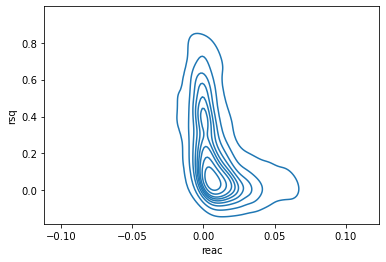

In [36]:
sns.kdeplot(data=wide_h9_reac2rsq.loc[wide_h9_reac2rsq.index.isin(pum2_peaks.index)], x="reac", y="rsq")

In [8]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="grey")
    return ax

def plot_confidence_intervals(dsi_nts_num_input, ax, colx='tx.len', coly='dsi_len'):
    dsi_nts_num = dsi_nts_num_input.copy()
    x = dsi_nts_num[colx]
    y = dsi_nts_num[coly]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print (slope, intercept, r_value, p_value)
    
    # Modeling with Numpy
    def equation(a, b):
        """Return a 1D polynomial."""
        return np.polyval(a, b) 

    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x) 
    
    # Statistics
    n = x.size                                                 # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.95, n - m)                              # used for CI and PI bands
    
    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
    
    
    # Data
    #ax.plot(
    #    x, y, "o", color="#b9cfe7", markersize=6, 
    #    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
    #)
    
    
    # Fit
    ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.1, label="Fit") 
        
    # add the prediction limits band to comparing_htg matrix
    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)
    #plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))  
    
    y_prediction = equation(p, x)
    pi_prediction = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    dsi_nts_num['up_prediction_limits'] = y_prediction + pi_prediction
    dsi_nts_num['low_prediction_limits'] = y_prediction - pi_prediction
    
    ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2 + pi, "--", color="0.5")
    
    up_outlies = dsi_nts_num.loc[dsi_nts_num[coly]>dsi_nts_num['up_prediction_limits']]
    low_outlies = dsi_nts_num.loc[dsi_nts_num[coly]<dsi_nts_num['low_prediction_limits']]
    outlies = pd.concat([up_outlies, low_outlies])
    #sns.scatterplot(data=up_outlies, x=colx, y=coly, s=7, alpha=1, ax=ax, color="orange")
    #for (gene,pos), row in up_outlies.iterrows():
        #ax.text(row[colx], row[coly], pos, color="orange")
    return outlies, 

-31.70177291503418 0.37325233636251687 -0.8739104998779764 1.3677145991522906e-10


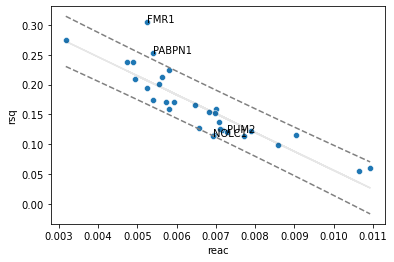

In [47]:
selected_rbp_targets_reac2rsq = rbp_targets_reac2rsq.loc[enriched_rbps]

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=selected_rbp_targets_reac2rsq, x="reac", y="rsq", ax=ax)
outliers = plot_confidence_intervals(selected_rbp_targets_reac2rsq,  ax, colx="reac", coly='rsq')
for gene, row in outliers[0].iterrows():
    x = row['reac']
    y = row['rsq']
    ax.text(x,y,gene)
pum2_row = rbp_targets_reac2rsq.loc['PUM2']
x = pum2_row['reac']
y = pum2_row['rsq']
ax.text(x,y,"PUM2")
plt.show()

### 2.2 RBP enrichment on hetero/reac wins

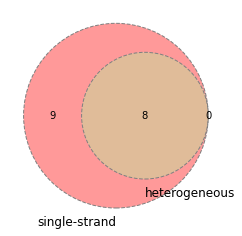

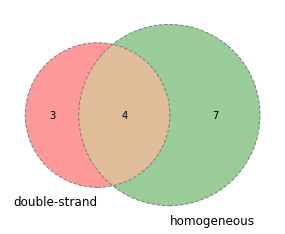

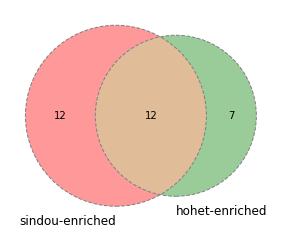

In [16]:
rbp_enrich_at_rsq = load_large_dataFrame("../Current_Data/07.RBP_targets/rbp_enrich_heterogeneity.all.from_zt.csv", index_col=None)
rbp_enrich_at_rsq
rbp_enrich_at_reac = load_large_dataFrame("../Current_Data/07.RBP_targets/zhangyu_rbp_enrichment.from_zt.txt", index_col=None, sep="\t")
rbp_enrich_at_reac
h9_rbp_enrich_at_rsq = rbp_enrich_at_rsq.loc[rbp_enrich_at_rsq['stage']=="h9"]
h9_rbp_enrich_at_reac = rbp_enrich_at_reac.loc[rbp_enrich_at_reac['stage']=="h9"]

_, adj_pval, _, _ = multitest.multipletests(h9_rbp_enrich_at_reac['pval_fisher'])
h9_rbp_enrich_at_reac['adj_pval'] = adj_pval
h9_rbp_enrich_at_reac['log10adj_pval'] = np.log10(h9_rbp_enrich_at_reac['adj_pval'])*-1
h9_rbp_enrich_at_rsq['log10adj_pval'] = np.log10(h9_rbp_enrich_at_rsq['qValue'])*-1
h9_rbp_enrich_at_rsq = h9_rbp_enrich_at_rsq.pivot(index="RBP", columns="group", values=['log10adj_pval'])
h9_rbp_enrich_at_reac = h9_rbp_enrich_at_reac.pivot(index="rbp", columns="qtl", values=['log10adj_pval'])
h9_rbp_enrich_at_rsq.columns = h9_rbp_enrich_at_rsq.columns.get_level_values('group')
h9_rbp_enrich_at_reac.columns = h9_rbp_enrich_at_reac.columns.get_level_values('qtl')


ss_enriched_rbps = set(h9_rbp_enrich_at_reac.loc[h9_rbp_enrich_at_reac[1.0]>-1*np.log10(0.05)].index.to_list())
ds_enriched_rbps = set(h9_rbp_enrich_at_reac.loc[h9_rbp_enrich_at_reac[0.25]>-1*np.log10(0.05)].index.to_list())

homo_enriched_rbps = set(h9_rbp_enrich_at_rsq.loc[h9_rbp_enrich_at_rsq[4]>-1*np.log10(0.05)].index.to_list())
hetero_enriched_rbps = set(h9_rbp_enrich_at_rsq.loc[h9_rbp_enrich_at_rsq[1]>-1*np.log10(0.05)].index.to_list())


from matplotlib_venn import venn2, venn2_circles, venn3, venn2_circles, venn3_circles

venn2([ss_enriched_rbps, hetero_enriched_rbps], ['single-strand', 'heterogeneous'])
venn2_circles([ss_enriched_rbps, hetero_enriched_rbps], linestyle='dashed', linewidth=1, color="grey")
plt.show()

venn2([ds_enriched_rbps, homo_enriched_rbps], ['double-strand', 'homogeneous'])
venn2_circles([ds_enriched_rbps, homo_enriched_rbps], linestyle='dashed', linewidth=1, color="grey")
plt.show()


all_sidou_enriched_rbps = set(list(ss_enriched_rbps)+list(ds_enriched_rbps))
all_hohet_enriched_rbps = set(list(hetero_enriched_rbps)+list(homo_enriched_rbps))
venn2([all_sidou_enriched_rbps, all_hohet_enriched_rbps], ['sindou-enriched', 'hohet-enriched'])
venn2_circles([all_sidou_enriched_rbps, all_hohet_enriched_rbps], linestyle='dashed', linewidth=1, color="grey")
plt.show()

In [17]:
#for a in all_hohet_enriched_rbps:
#    print (a)
    
#for a in all_sidou_enriched_rbps:
#    print (a)
    
    
enriched_rbps = list(set([a for a in all_hohet_enriched_rbps] +  [a for a in all_sidou_enriched_rbps]))
enriched_rbps

['SUB1',
 'FUBP3',
 'AKAP1',
 'TRA2A',
 'GRWD1',
 'APOBEC3C',
 'YBX3',
 'PABPC4',
 'RPS3',
 'CPSF6',
 'PCBP1',
 'KHSRP',
 'HLTF',
 'LIN28B',
 'METAP2',
 'NOLC1',
 'ZNF622',
 'CSTF2T',
 'IGF2BP1',
 'PABPN1',
 'LARP4',
 'UCHL5',
 'PPIG',
 'BCLAF1',
 'PUM2',
 'FMR1',
 'AGGF1',
 'DDX6',
 'TIA1',
 'UPF1',
 'DDX3X']

In [106]:
rbp_binding_wins



rbp rbp_with_conditions   cell target_ensembl_id
target pos                                                       
SNAPC3 5050   GTF2F1    GTF2F1_HepG2_IDR  HepG2   ENST00000380821
       5060   GTF2F1    GTF2F1_HepG2_IDR  HepG2   ENST00000380821
       5070   GTF2F1    GTF2F1_HepG2_IDR  HepG2   ENST00000380821
       5080   GTF2F1    GTF2F1_HepG2_IDR  HepG2   ENST00000380821
       5090   GTF2F1    GTF2F1_HepG2_IDR  HepG2   ENST00000380821
...              ...                 ...    ...               ...
TRIM13 140   SUPV3L1   SUPV3L1_HepG2_IDR  HepG2   ENST00000356017
       150   SUPV3L1   SUPV3L1_HepG2_IDR  HepG2   ENST00000356017
       160   SUPV3L1   SUPV3L1_HepG2_IDR  HepG2   ENST00000356017
       170   SUPV3L1   SUPV3L1_HepG2_IDR  HepG2   ENST00000356017
       180   SUPV3L1   SUPV3L1_HepG2_IDR  HepG2   ENST00000356017

[2663570 rows x 4 columns]

## 3.

### 3.1 diff_expr RBPs

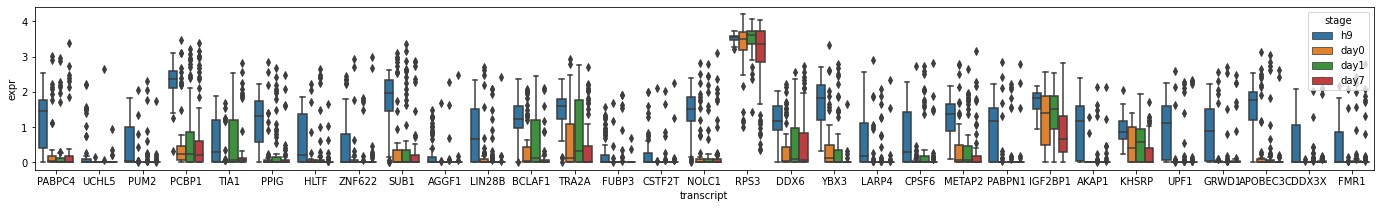

In [94]:
rbp_expr = gene_expr.loc[gene_expr.index.isin(enriched_rbps)]
rbp_expr = pd.DataFrame(np.log10(rbp_expr+1))
rbp_expr = rbp_expr.stack([0,1,2,3]).to_frame('expr')
rbp_expr = rbp_expr.reset_index()

t = pd.CategoricalDtype(categories=['h9','day0','day1','day7'], ordered=True)
rbp_expr['stage'] =  rbp_expr['stage'].astype(t)

fig, ax = plt.subplots(1,1, figsize=(24,3))
sns.boxplot(data=rbp_expr, x="transcript", y="expr", hue="stage", ax=ax)
plt.show()

### 3.2 Single/Double OR Homo/Hetero target sites of each RBP

PABPC4
515 514


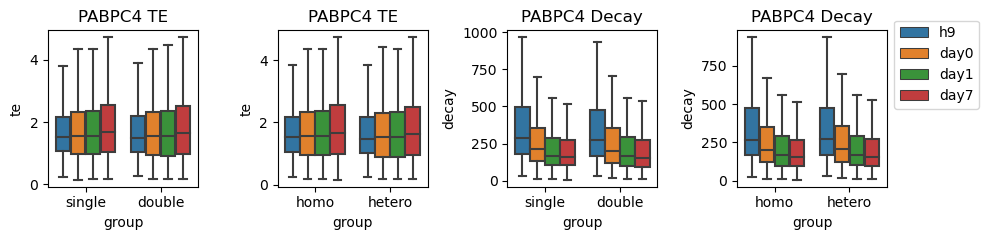

DDX6
134 134


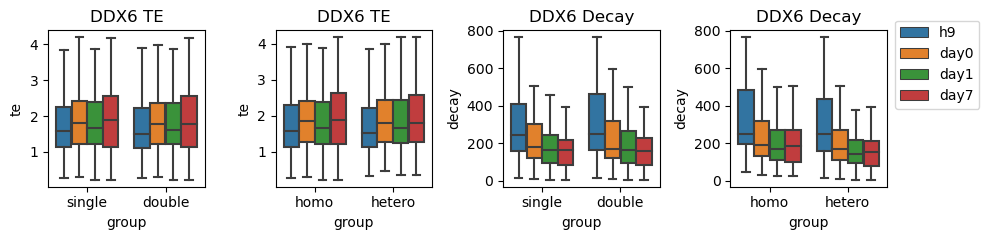

TIA1
128 128


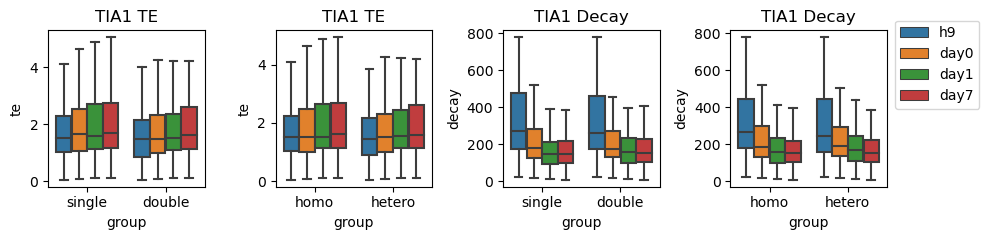

BCLAF1
142 145


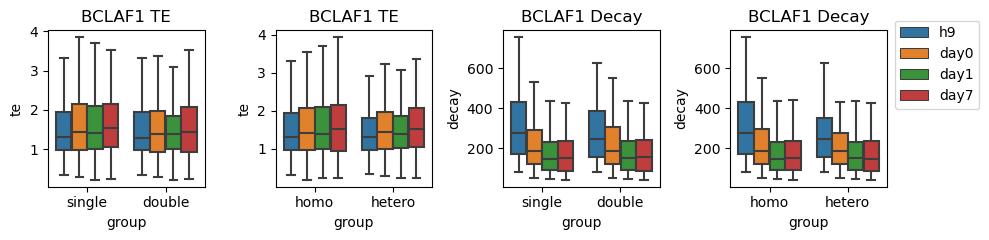

RPS3
298 299


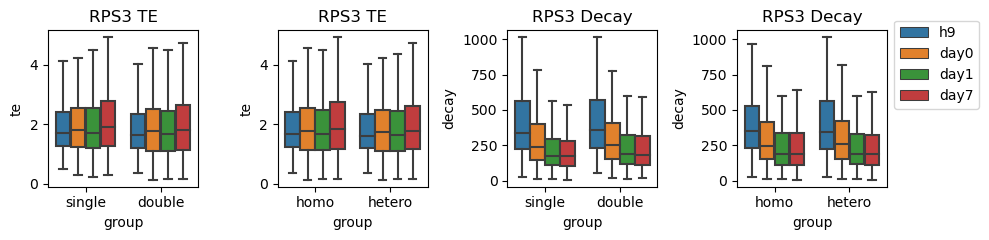

TRA2A
50 49


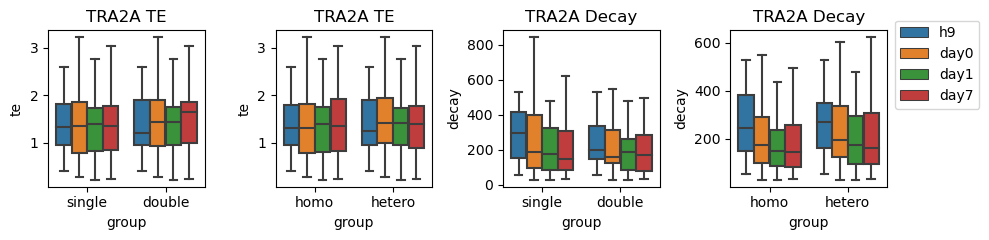

CSTF2T
8 6


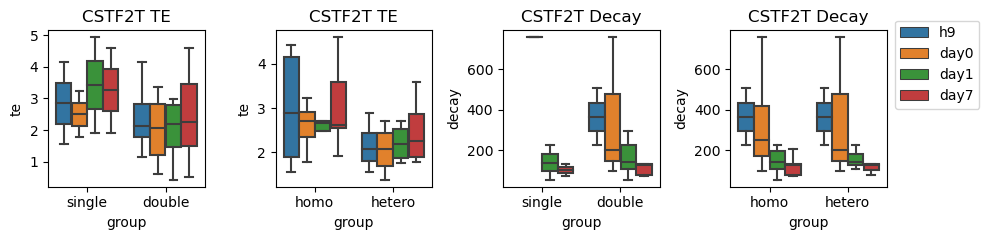

LARP4
500 497


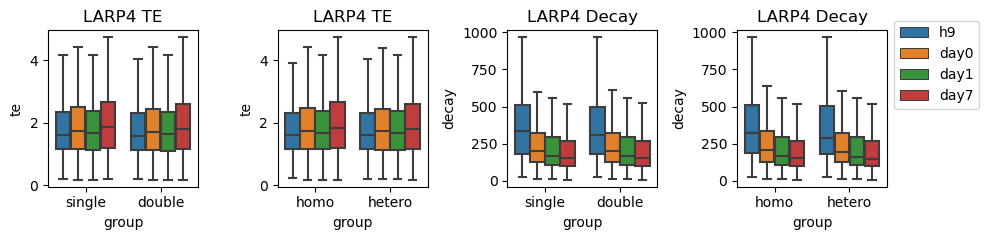

SUB1
325 325


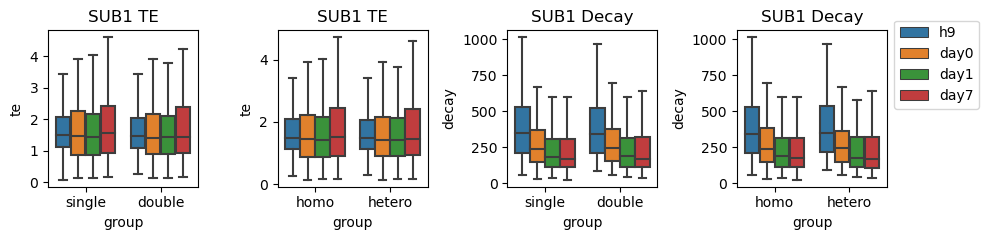

PUM2
149 146


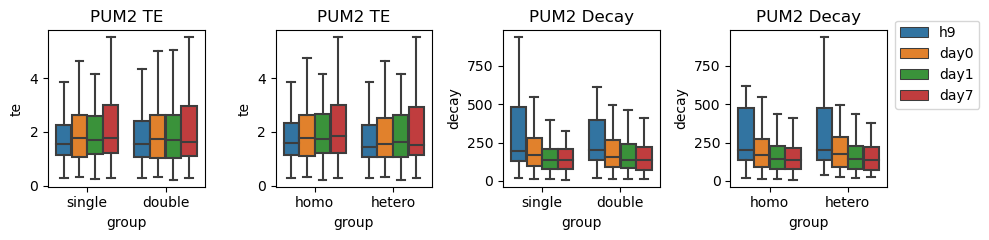

METAP2
155 157


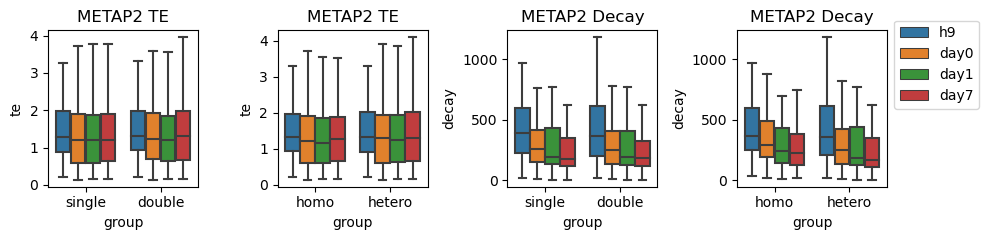

FMR1
49 47


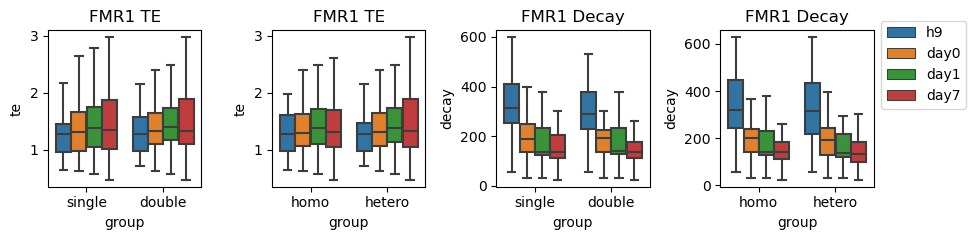

UPF1
238 239


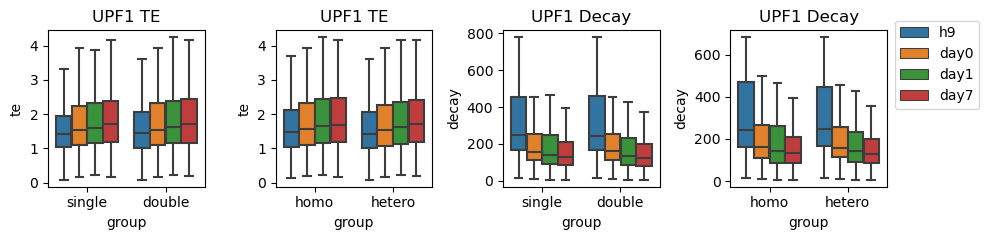

AGGF1
15 15


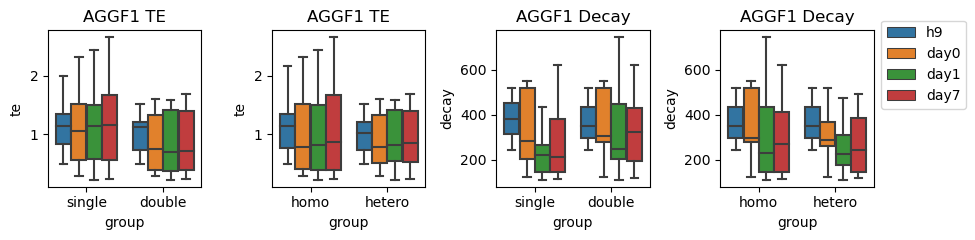

HLTF
14 14


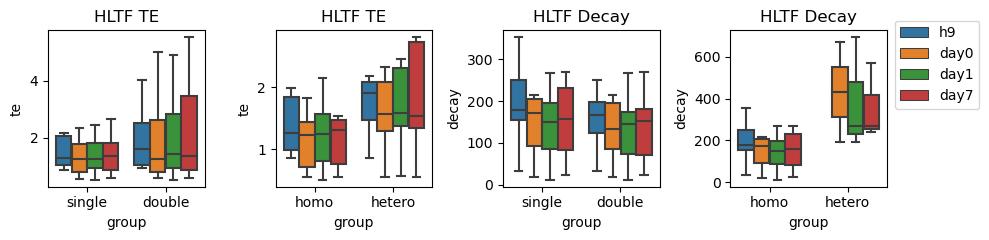

NOLC1
162 162


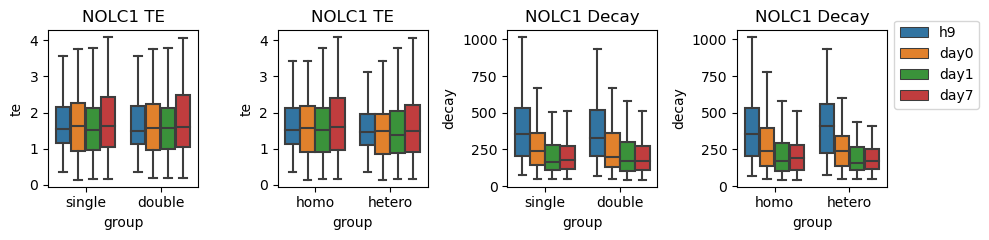

DDX3X
317 313


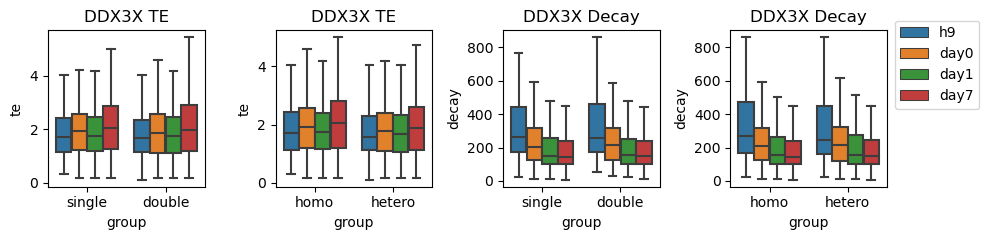

APOBEC3C
211 203


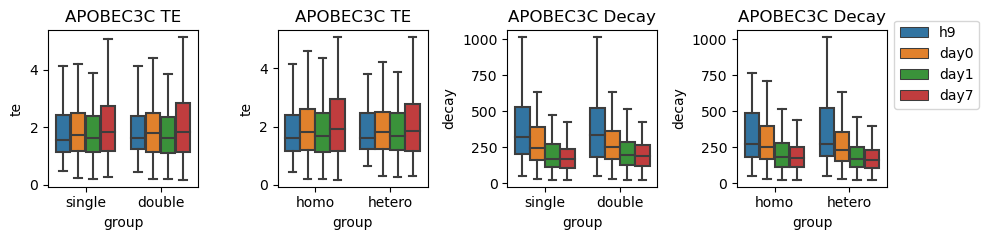

UCHL5
202 207


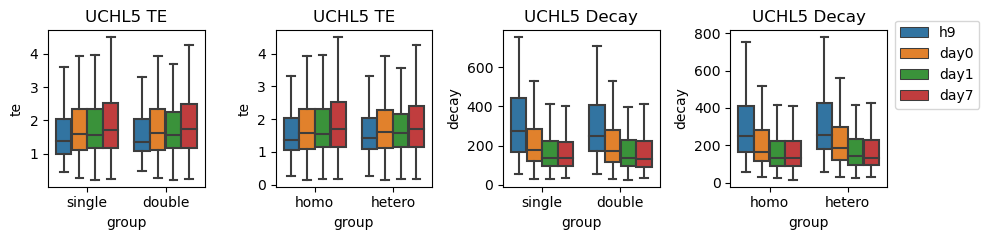

CPSF6
24 25


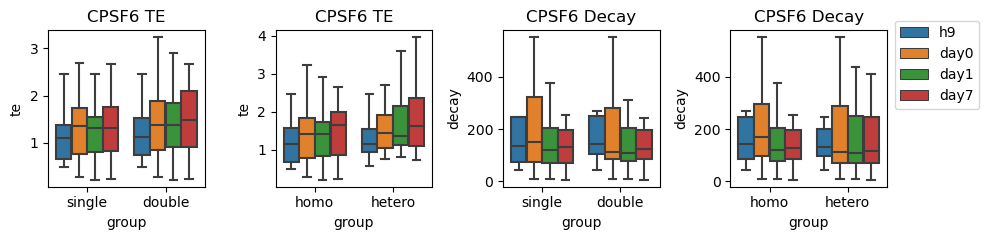

KHSRP
11 11


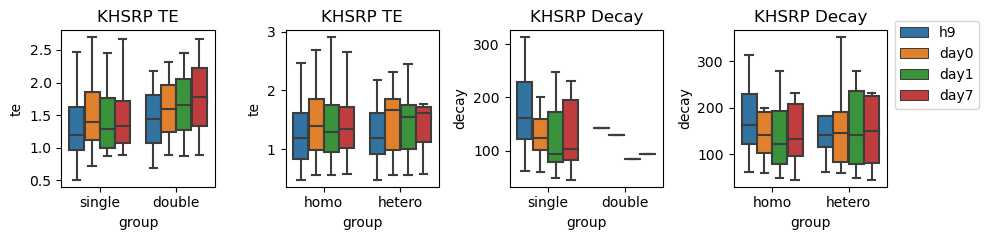

FUBP3
25 23


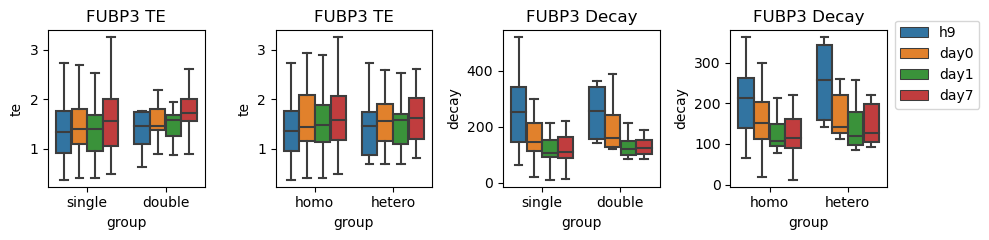

PPIG
124 126


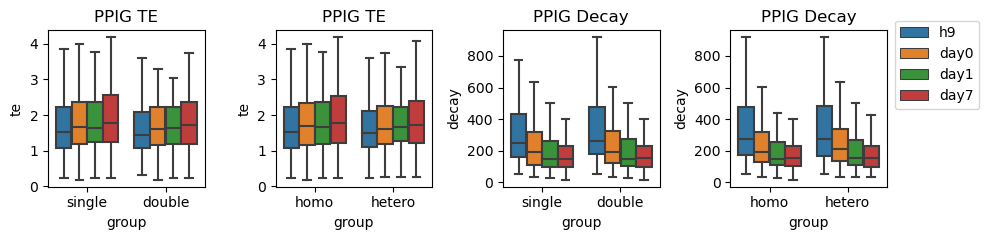

LIN28B
291 286


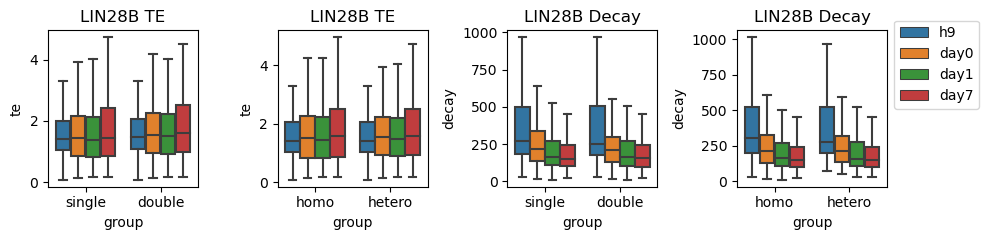

PCBP1
138 139


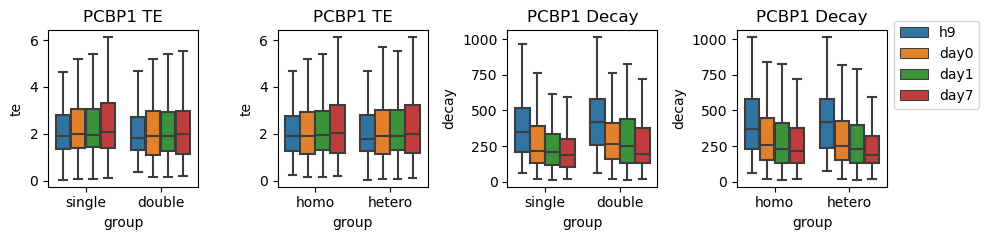

GRWD1
306 303


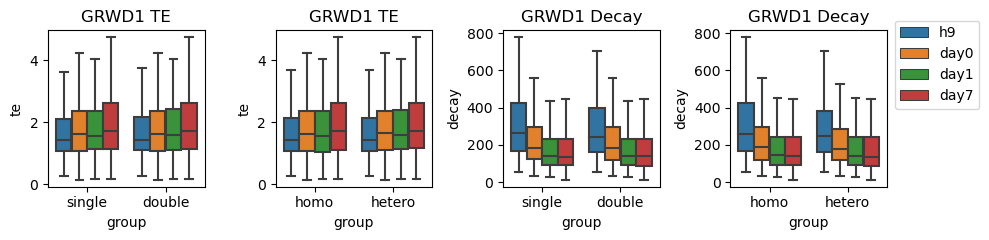

PABPN1
90 91


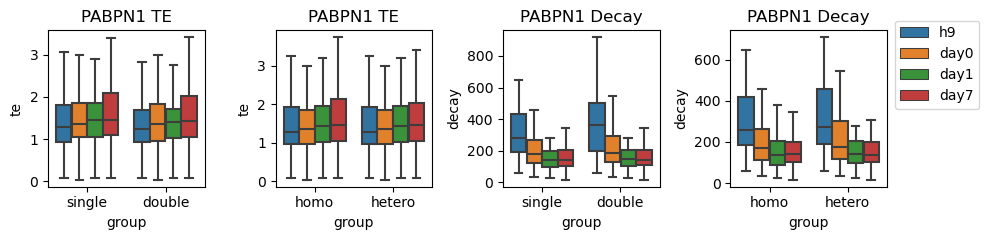

YBX3
451 450


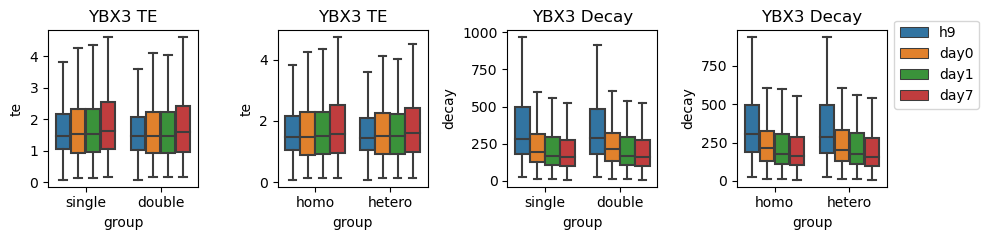

ZNF622
114 115


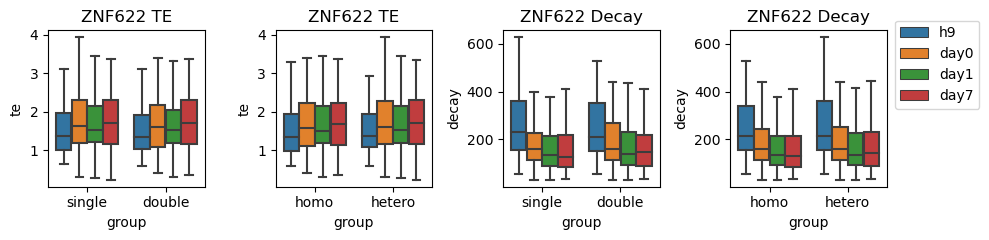

IGF2BP1
181 176


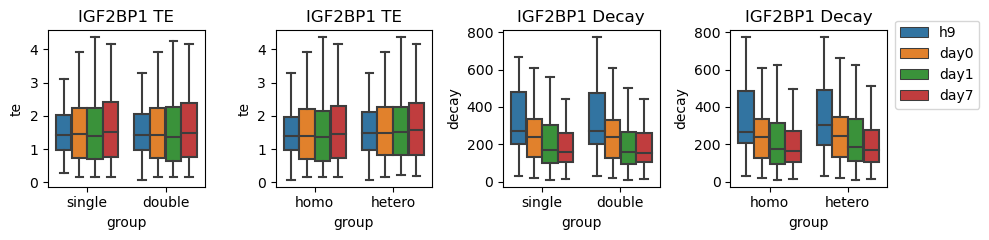

AKAP1
144 144


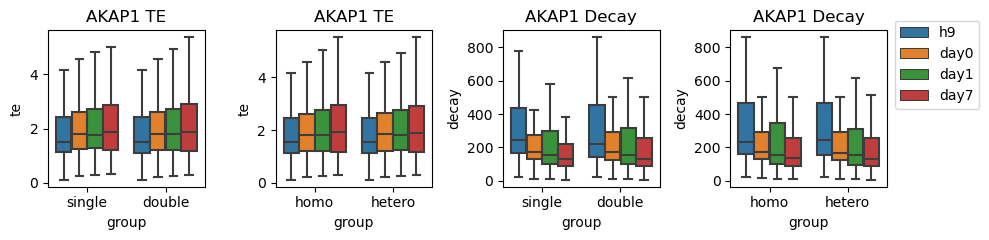

In [112]:
for rbp in enriched_rbps:
    print (rbp)
    rbp_targets = rbp_binding_wins.loc[rbp_binding_wins['rbp']==rbp]
    
    rbp_targets_reac2rsq = wide_h9_reac2rsq.loc[wide_h9_reac2rsq.index.isin(rbp_targets.index)]
    
    rbp_targets_single = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['reac.qtl']==4]
    rbp_targets_double = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['reac.qtl']==1]
    rbp_targets_hetero = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['rsq.qtl']==4]
    rbp_targets_homo = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['rsq.qtl']==1]
    
    rbp_targets_single_genes = gene_te_and_decay.loc[gene_te_and_decay.index.isin(rbp_targets_single.index.get_level_values('gene'))]
    rbp_targets_double_genes = gene_te_and_decay.loc[gene_te_and_decay.index.isin(rbp_targets_double.index.get_level_values('gene'))]
    rbp_targets_homo_genes = gene_te_and_decay.loc[gene_te_and_decay.index.isin(rbp_targets_homo.index.get_level_values('gene'))]
    rbp_targets_hetero_genes = gene_te_and_decay.loc[gene_te_and_decay.index.isin(rbp_targets_hetero.index.get_level_values('gene'))]
    
    
    rbp_targets_single_genes['group'] = "single"
    rbp_targets_double_genes['group'] = "double"
    rbp_targets_s2d = pd.concat([rbp_targets_single_genes, rbp_targets_double_genes])
    rbp_targets_homo_genes['group'] = "homo"
    rbp_targets_hetero_genes['group'] = "hetero"
    rbp_targets_h2h = pd.concat([rbp_targets_homo_genes, rbp_targets_hetero_genes])
    #print (rbp_targets_h2h)
    print (rbp_targets_s2d.index.get_level_values('gene').unique().size, rbp_targets_h2h.index.get_level_values('gene').unique().size)
    
    fig, axs = plt.subplots(1,4, figsize=(10,2.5))
    ax = axs[0]
    sns.boxplot(data=rbp_targets_s2d, x="group", y="te", hue="stage", ax=ax, showfliers=False)
    ax.get_legend().remove()
    ax.set_title(rbp+" TE")
    ax = axs[1]
    sns.boxplot(data=rbp_targets_h2h, x="group", y="te", hue="stage", ax=ax, showfliers=False)
    #ax.legend(loc=[1.05,0.5])
    ax.get_legend().remove()
    ax.set_title(rbp+" TE")
    
    ax = axs[2]
    sns.boxplot(data=rbp_targets_s2d, x="group", y="decay", hue="stage", ax=ax, showfliers=False)
    ax.get_legend().remove()
    ax.set_title(rbp+" Decay")
    ax = axs[3]
    sns.boxplot(data=rbp_targets_h2h, x="group", y="decay", hue="stage", ax=ax, showfliers=False)
    ax.legend(loc=[1.05,0.5])
    ax.set_title(rbp+" Decay")
    plt.tight_layout()
    plt.show()
    

### 3.3 the different Consequence of RBP targets

APOBEC3C


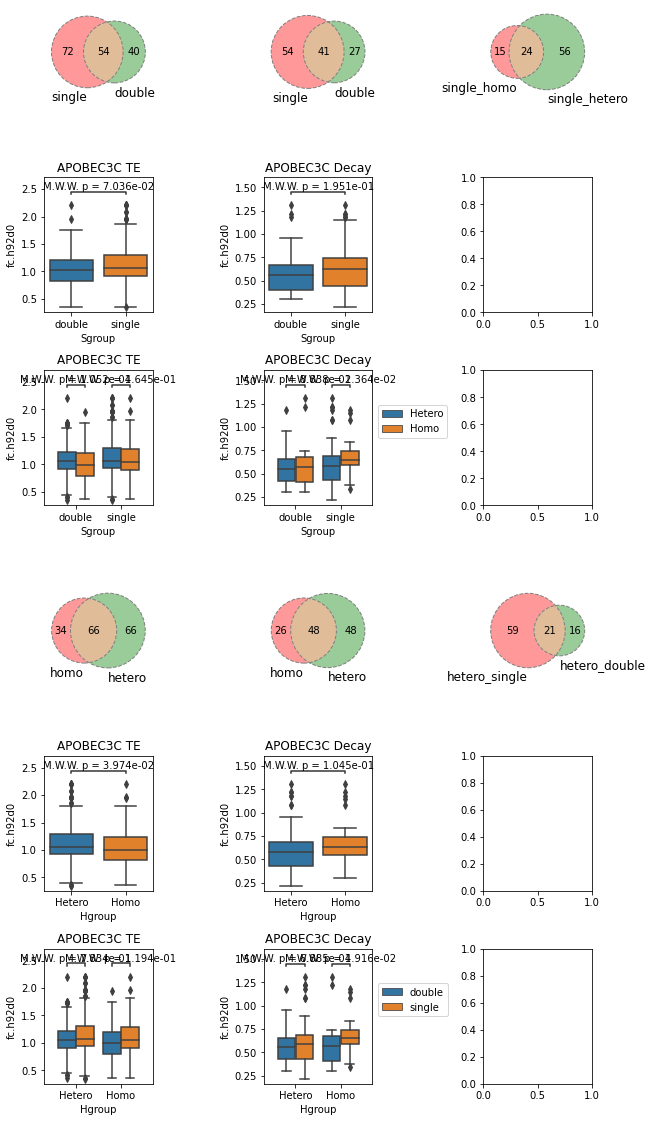

GRWD1


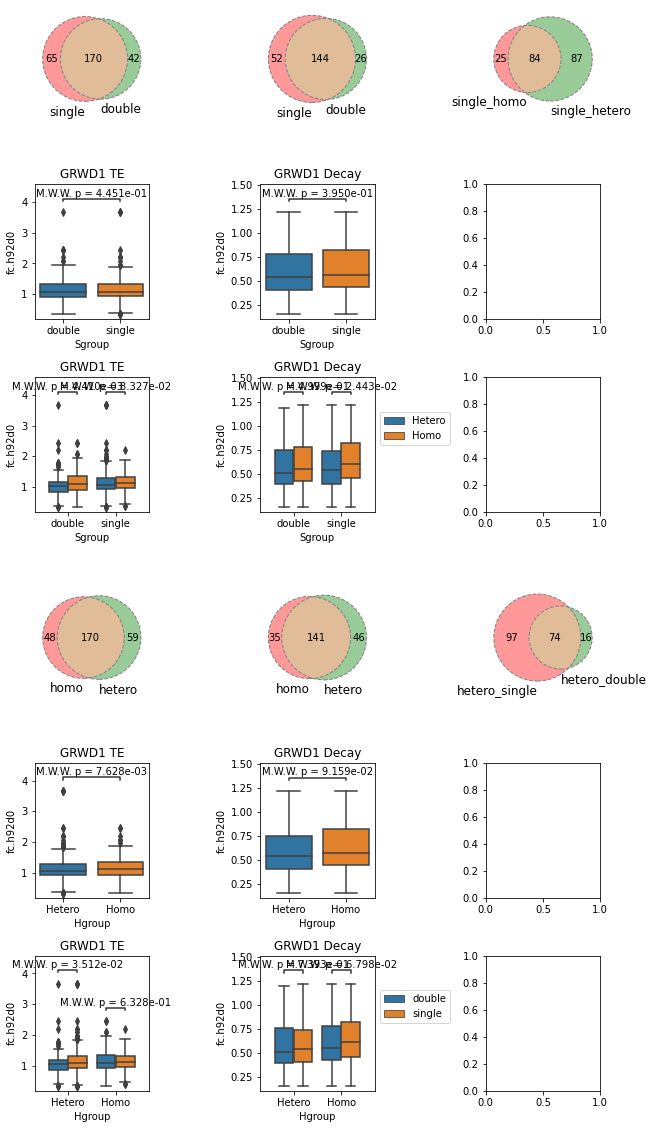

YBX3


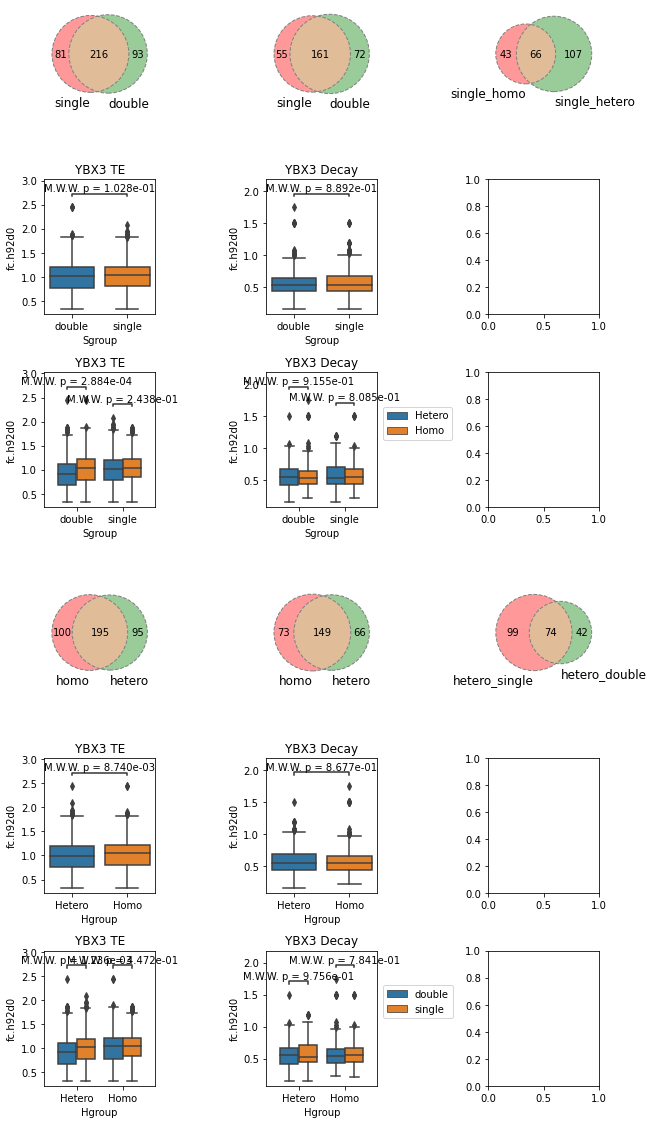

PUM2


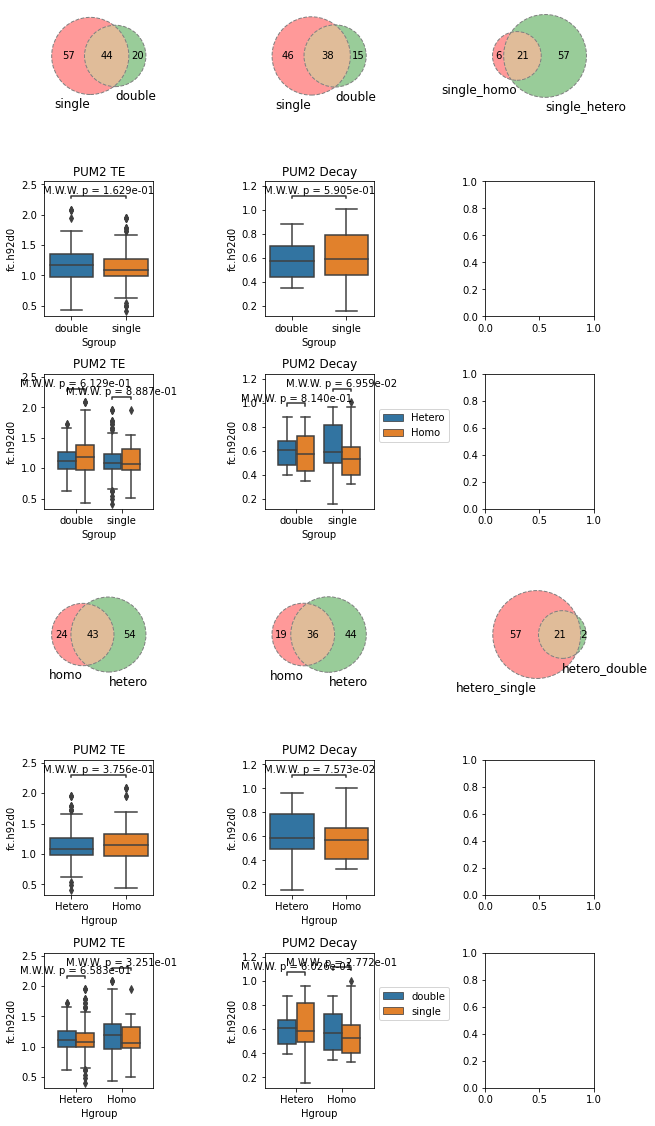

In [79]:
#for rbp in enriched_rbps:
for rbp in ['APOBEC3C', 'GRWD1','YBX3','PUM2']:
    
    #if rbp != "PUM2":
    #    continue
    print (rbp)
    
    rbp_targets = rbp_binding_wins.loc[rbp_binding_wins['rbp']==rbp]    
    rbp_targets_reac2rsq = wide_h9_reac2rsq.loc[wide_h9_reac2rsq.index.isin(rbp_targets.index)]

    def add_win_labeling(table):
        table['group'] = np.nan

        table.loc[(table['reac.qtl']==4)&(table['rsq.qtl']==1), "group"] = "single_hetero"
        table.loc[(table['reac.qtl']==4)&(table['rsq.qtl']==4), "group"] = "single_homo"
        table.loc[(table['reac.qtl']==1)&(table['rsq.qtl']==1), "group"] = "double_hetero"
        table.loc[(table['reac.qtl']==1)&(table['rsq.qtl']==4), "group"] = "double_homo"
        
        table.loc[(table['reac.qtl']==4)&(~table['rsq.qtl'].isin([1,4])), "group"] = "single_mediate"
        table.loc[(table['reac.qtl']==1)&(~table['rsq.qtl'].isin([1,4])), "group"] = "double_mediate"
        table.loc[(~table['reac.qtl'].isin([1,4]))&(table['rsq.qtl']==4), "group"] = "mediate_homo"
        table.loc[(~table['reac.qtl'].isin([1,4]))&(table['rsq.qtl']==1), "group"] = "mediate_hetero"
        table.loc[(~table['reac.qtl'].isin([1,4]))&(~table['rsq.qtl'].isin([1,4])), "group"] = "mediate_mediate"
        
        
        table['Sgroup'] = np.nan
        table.loc[table['reac.qtl']==4, 'Sgroup'] = "single"
        table.loc[table['reac.qtl']==1, 'Sgroup'] = "double"
        table.loc[(table['reac.qtl']!=1)&(table['reac.qtl']!=4), 'Sgroup'] = "mediate"
        table['Hgroup'] = np.nan
        table.loc[table['rsq.qtl']==4, 'Hgroup'] = "Homo"
        table.loc[table['rsq.qtl']==1, 'Hgroup'] = "Hetero"
        table.loc[(table['rsq.qtl']!=1)&(table['rsq.qtl']!=4), 'Hgroup'] = "mediate"
        return table
    
    rbp_targets_reac2rsq = add_win_labeling(rbp_targets_reac2rsq)

    rbp_targets_single = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['reac.qtl']==4]
    rbp_targets_double = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['reac.qtl']==1]
    rbp_targets_hetero = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['rsq.qtl']==4]
    rbp_targets_homo = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['rsq.qtl']==1]     
            
    local_gene_delta_te = gene_delta_te[['fc.h92d0']].merge(rbp_targets_reac2rsq.reset_index(), left_index=True, right_on="gene", how="inner", validate="1:m")
    local_gene_delta_decay = gene_delta_decay[['fc.h92d0']].merge(rbp_targets_reac2rsq.reset_index(), left_index=True, right_on="gene", how="inner", validate="1:m")
    
    
    
    """local_gene_te_and_decay = gene_delta_te
    rbp_targets_single_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_single.index.get_level_values('gene'))]
    rbp_targets_double_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_double.index.get_level_values('gene'))]
    rbp_targets_homo_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_homo.index.get_level_values('gene'))]
    rbp_targets_hetero_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_hetero.index.get_level_values('gene'))]
    
    rbp_targets_s2d = pd.concat([rbp_targets_single_genes, rbp_targets_double_genes])
    rbp_targets_h2h = pd.concat([rbp_targets_homo_genes, rbp_targets_hetero_genes])
    
    print (rbp_targets_s2d.index.get_level_values('gene').unique().size, rbp_targets_h2h.index.get_level_values('gene').unique().size)
    
    print (rbp_targets_s2d)"""
    local_gene_delta_te = local_gene_delta_te.loc[(local_gene_delta_te['Hgroup']!="mediate")&(local_gene_delta_te['Sgroup']!="mediate")]
    local_gene_delta_decay = local_gene_delta_decay.loc[(local_gene_delta_decay['Hgroup']!="mediate")&(local_gene_delta_decay['Sgroup']!="mediate")]
    
    local_gene_delta_te = local_gene_delta_te.sort_values('group')
    local_gene_delta_decay = local_gene_delta_decay.sort_values('group')
    
    
    fig, axs = plt.subplots(6,3, figsize=(9,16))
    
    ax = axs[0,0]
    single_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Sgroup']=="single","gene"].unique())
    double_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Sgroup']=="double","gene"].unique())
    venn2([single_genes, double_genes], ['single', 'double'], ax=ax)
    venn2_circles([single_genes, double_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    ax = axs[0,1]
    single_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Sgroup']=="single","gene"].unique())
    double_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Sgroup']=="double","gene"].unique())
    venn2([single_genes, double_genes], ['single', 'double'], ax=ax)
    venn2_circles([single_genes, double_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    ax = axs[0,2]
    single_homo_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Sgroup']=="single")&(local_gene_delta_decay['Hgroup']=="Homo"),"gene"].unique())
    single_hetero_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Sgroup']=="single")&(local_gene_delta_decay['Hgroup']=="Hetero"),"gene"].unique())
    venn2([single_homo_genes, single_hetero_genes], ['single_homo', 'single_hetero'], ax=ax)
    venn2_circles([single_homo_genes, single_hetero_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    ax = axs[1,0]
    sns.boxplot(data=local_gene_delta_te, x="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Sgroup", y="fc.h92d0", 
                                           box_pairs=[('single','double'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" TE")
    ax = axs[1,1]
    sns.boxplot(data=local_gene_delta_decay, x="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Sgroup", y="fc.h92d0", 
                                           box_pairs=[('single','double'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" Decay")

    ax = axs[2,0]
    sns.boxplot(data=local_gene_delta_te, x="Sgroup", hue="Hgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Sgroup", hue="Hgroup", y="fc.h92d0", 
                                           box_pairs=[(('single', 'Homo'),('single', 'Hetero')),
                                                      (('double', 'Homo'),('double', 'Hetero')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.get_legend().remove()
    ax.set_title(rbp+" TE")
    ax = axs[2,1]
    sns.boxplot(data=local_gene_delta_decay, x="Sgroup", hue="Hgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Sgroup", hue="Hgroup", y="fc.h92d0",
                                           box_pairs=[(('single', 'Homo'),('single', 'Hetero')),
                                                      (('double', 'Homo'),('double', 'Hetero')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.legend(loc=[1.05,0.5])
    ax.set_title(rbp+" Decay")
    
    ax = axs[3,0]
    homo_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Hgroup']=="Homo","gene"].unique())
    hetero_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Hgroup']=="Hetero","gene"].unique())
    venn2([homo_genes, hetero_genes], ['homo', 'hetero'], ax=ax)
    venn2_circles([homo_genes, hetero_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    ax = axs[3,1]
    homo_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Hgroup']=="Homo","gene"].unique())
    hetero_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Hgroup']=="Hetero","gene"].unique())
    venn2([homo_genes, hetero_genes], ['homo', 'hetero'], ax=ax)
    venn2_circles([homo_genes, hetero_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    ax = axs[3,2]
    homo_single_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Hgroup']=="Hetero")&(local_gene_delta_decay['Sgroup']=="single"),"gene"].unique())
    homo_double_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Hgroup']=="Hetero")&(local_gene_delta_decay['Sgroup']=="double"),"gene"].unique())
    venn2([homo_single_genes, homo_double_genes], ['hetero_single', 'hetero_double'], ax=ax)
    venn2_circles([homo_single_genes, homo_double_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    
    ax = axs[4,0]
    sns.boxplot(data=local_gene_delta_te, x="Hgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Hgroup", y="fc.h92d0", 
                                           box_pairs=[('Homo','Hetero'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" TE")
    ax = axs[4,1]
    sns.boxplot(data=local_gene_delta_decay, x="Hgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Hgroup", y="fc.h92d0", 
                                           box_pairs=[('Homo','Hetero'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" Decay")
    
    
    ax = axs[5,0]
    sns.boxplot(data=local_gene_delta_te, x="Hgroup", hue="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Hgroup", hue="Sgroup", y="fc.h92d0",
                                           box_pairs=[(('Homo','single'),('Homo', 'double')),
                                                      (('Hetero','single'),('Hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    #ax.legend(loc=[1.05,0.5])
    ax.get_legend().remove()
    ax.set_title(rbp+" TE")
    ax = axs[5,1]
    sns.boxplot(data=local_gene_delta_decay, x="Hgroup", hue="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Hgroup", hue="Sgroup", y="fc.h92d0",
                                           box_pairs=[(('Homo','single'),('Homo', 'double')),
                                                      (('Hetero','single'),('Hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.legend(loc=[1.05,0.5])
    ax.set_title(rbp+" Decay")

    plt.tight_layout()
    plt.savefig("../Current_Figures/05.Consequence_of_heterogeneity/te_and_decay.consequence.{}.pval.pdf".format(rbp))
    plt.show()
    
    
    

In [148]:
gene_delta_te[['fc.h92d0']].merge(rbp_targets_reac2rsq.reset_index(), left_index=True, right_on="gene", how="inner", validate="1:m")

,fc.h92d0,gene,pos,reac,reac.qtl,rsq,rsq.qtl,group,Sgroup,Hgroup
20,0.661247,CALD1,370,0.005787,2,0.454421,4,mediate_homo,mediate,single
21,0.661247,CALD1,380,0.008553,3,0.011224,1,mediate_hetero,mediate,double
22,0.661247,CALD1,390,0.009911,4,0.733602,4,single_homo,single,single
23,0.661247,CALD1,400,0.007069,3,0.575912,4,mediate_homo,mediate,single
24,0.661247,CALD1,410,0.009822,4,0.000017,1,single_hetero,single,double
...,...,...,...,...,...,...,...,...,...,...
203,1.381547,SON,250,0.014079,4,0.000463,1,single_hetero,single,double
204,1.381547,SON,260,-0.000244,1,0.000049,1,double_hetero,double,double
205,1.381547,SON,270,0.012010,4,0.367244,3,single_mediate,single,mediate
206,1.381547,SON,280,0.005259,2,0.461302,4,mediate_homo,mediate,single


APOBEC3C


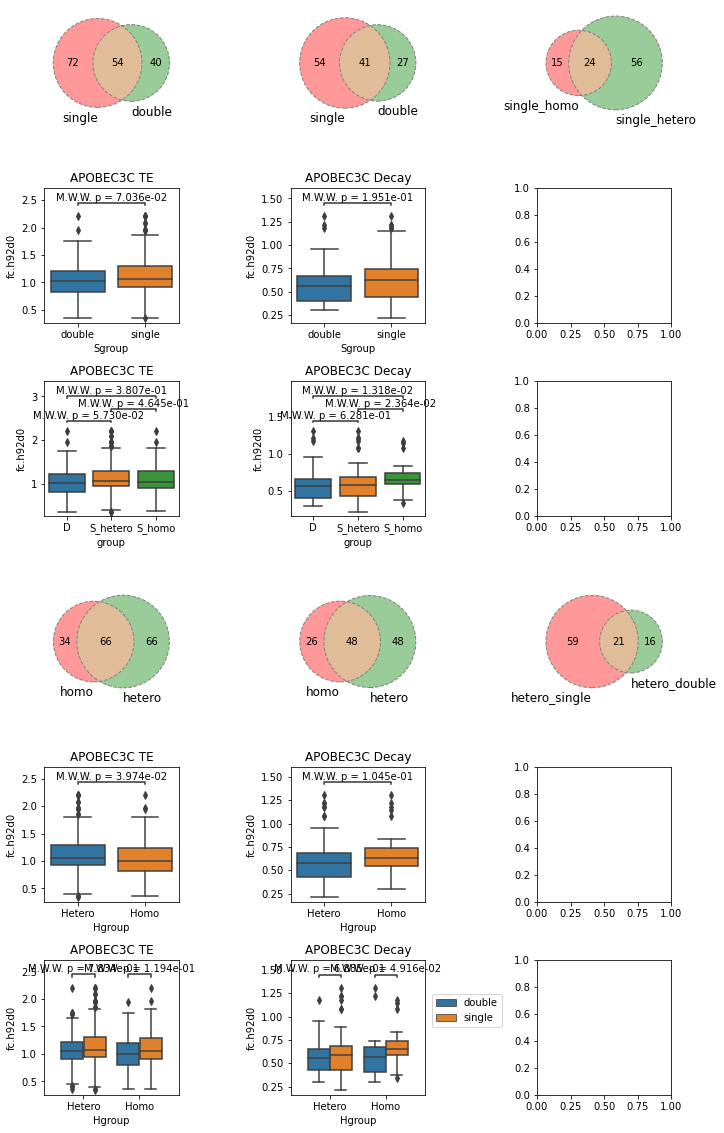

GRWD1


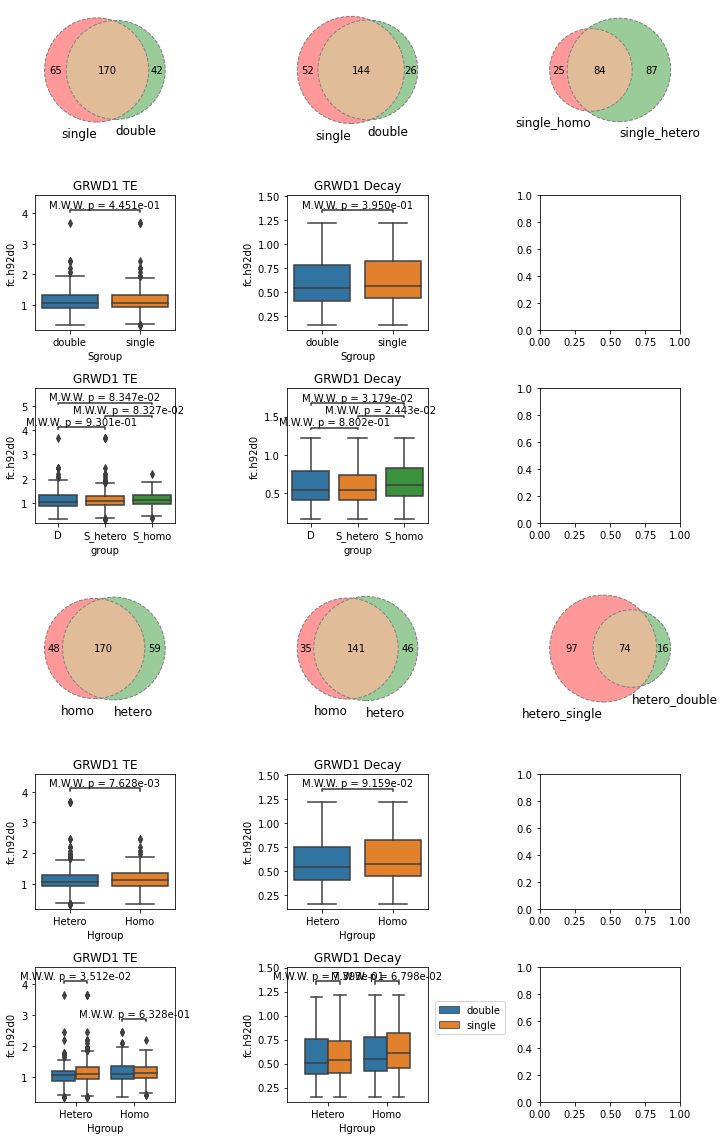

YBX3


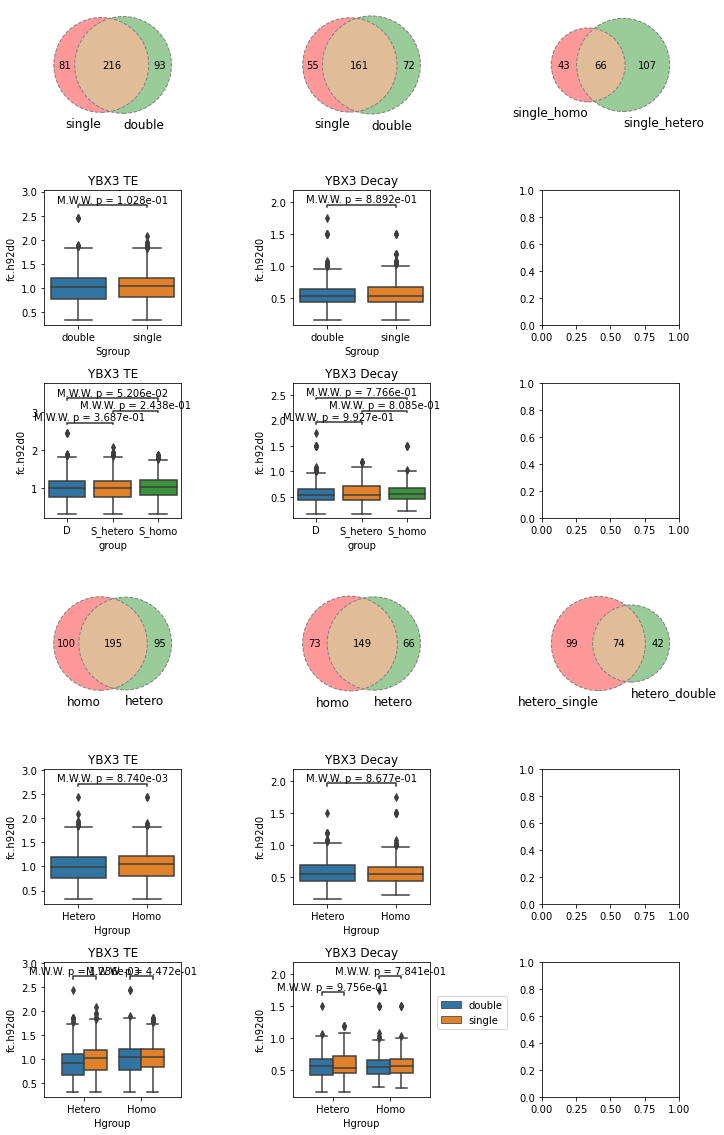

In [140]:
#for rbp in enriched_rbps:
#for rbp in ['PUM2', 'FMR1', 'PABPN1','NOLC1']:
for rbp in ['APOBEC3C', 'GRWD1','YBX3']:
    
    #if rbp != "PUM2":
    #    continue
    print (rbp)
    
    rbp_targets = rbp_binding_wins.loc[rbp_binding_wins['rbp']==rbp]    
    rbp_targets_reac2rsq = wide_h9_reac2rsq.loc[wide_h9_reac2rsq.index.isin(rbp_targets.index)]
    if rbp_targets_reac2rsq.index.get_level_values('gene').unique().size < 30:
        continue

    def add_win_labeling(table):
        table['group'] = np.nan

        table.loc[(table['reac.qtl']==4)&(table['rsq.qtl']==1), "group"] = "single_hetero"
        table.loc[(table['reac.qtl']==4)&(table['rsq.qtl']==4), "group"] = "single_homo"
        table.loc[(table['reac.qtl']==1)&(table['rsq.qtl']==1), "group"] = "double_hetero"
        table.loc[(table['reac.qtl']==1)&(table['rsq.qtl']==4), "group"] = "double_homo"
        
        table.loc[(table['reac.qtl']==4)&(~table['rsq.qtl'].isin([1,4])), "group"] = "single_mediate"
        table.loc[(table['reac.qtl']==1)&(~table['rsq.qtl'].isin([1,4])), "group"] = "double_mediate"
        table.loc[(~table['reac.qtl'].isin([1,4]))&(table['rsq.qtl']==4), "group"] = "mediate_homo"
        table.loc[(~table['reac.qtl'].isin([1,4]))&(table['rsq.qtl']==1), "group"] = "mediate_hetero"
        table.loc[(~table['reac.qtl'].isin([1,4]))&(~table['rsq.qtl'].isin([1,4])), "group"] = "mediate_mediate"
        
        
        table['Sgroup'] = np.nan
        table.loc[table['reac.qtl']==4, 'Sgroup'] = "single"
        table.loc[table['reac.qtl']==1, 'Sgroup'] = "double"
        table.loc[(table['reac.qtl']!=1)&(table['reac.qtl']!=4), 'Sgroup'] = "mediate"
        table['Hgroup'] = np.nan
        table.loc[table['rsq.qtl']==4, 'Hgroup'] = "Homo"
        table.loc[table['rsq.qtl']==1, 'Hgroup'] = "Hetero"
        table.loc[(table['rsq.qtl']!=1)&(table['rsq.qtl']!=4), 'Hgroup'] = "mediate"
        return table
    
    rbp_targets_reac2rsq = add_win_labeling(rbp_targets_reac2rsq)

    rbp_targets_single = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['reac.qtl']==4]
    rbp_targets_double = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['reac.qtl']==1]
    rbp_targets_hetero = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['rsq.qtl']==4]
    rbp_targets_homo = rbp_targets_reac2rsq.loc[rbp_targets_reac2rsq['rsq.qtl']==1]     
            
    local_gene_delta_te = gene_delta_te[['fc.h92d0']].merge(rbp_targets_reac2rsq.reset_index(), left_index=True, right_on="gene", how="inner", validate="1:m")
    local_gene_delta_decay = gene_delta_decay[['fc.h92d0']].merge(rbp_targets_reac2rsq.reset_index(), left_index=True, right_on="gene", how="inner", validate="1:m")
    
    
    
    """local_gene_te_and_decay = gene_delta_te
    rbp_targets_single_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_single.index.get_level_values('gene'))]
    rbp_targets_double_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_double.index.get_level_values('gene'))]
    rbp_targets_homo_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_homo.index.get_level_values('gene'))]
    rbp_targets_hetero_genes = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(rbp_targets_hetero.index.get_level_values('gene'))]
    
    rbp_targets_s2d = pd.concat([rbp_targets_single_genes, rbp_targets_double_genes])
    rbp_targets_h2h = pd.concat([rbp_targets_homo_genes, rbp_targets_hetero_genes])
    
    print (rbp_targets_s2d.index.get_level_values('gene').unique().size, rbp_targets_h2h.index.get_level_values('gene').unique().size)
    
    print (rbp_targets_s2d)"""
    local_gene_delta_te = local_gene_delta_te.loc[(local_gene_delta_te['Hgroup']!="mediate")&(local_gene_delta_te['Sgroup']!="mediate")]
    local_gene_delta_decay = local_gene_delta_decay.loc[(local_gene_delta_decay['Hgroup']!="mediate")&(local_gene_delta_decay['Sgroup']!="mediate")]
    
    local_gene_delta_te = local_gene_delta_te.sort_values('group')
    local_gene_delta_decay = local_gene_delta_decay.sort_values('group')
    local_gene_delta_te['group'] = local_gene_delta_te['group'].map({'single_homo':'S_homo','single_hetero':'S_hetero','double_homo':'D','double_hetero':'D'})
    local_gene_delta_te
    local_gene_delta_decay['group'] = local_gene_delta_decay['group'].map({'single_homo':'S_homo','single_hetero':'S_hetero','double_homo':'D','double_hetero':'D'})
    local_gene_delta_decay
    
    
    fig, axs = plt.subplots(6,3, figsize=(10,16))
    
    ax = axs[0,0]
    single_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Sgroup']=="single","gene"].unique())
    double_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Sgroup']=="double","gene"].unique())
    venn2([single_genes, double_genes], ['single', 'double'], ax=ax)
    venn2_circles([single_genes, double_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    ax = axs[0,1]
    single_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Sgroup']=="single","gene"].unique())
    double_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Sgroup']=="double","gene"].unique())
    venn2([single_genes, double_genes], ['single', 'double'], ax=ax)
    venn2_circles([single_genes, double_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    ax = axs[0,2]
    single_homo_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Sgroup']=="single")&(local_gene_delta_decay['Hgroup']=="Homo"),"gene"].unique())
    single_hetero_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Sgroup']=="single")&(local_gene_delta_decay['Hgroup']=="Hetero"),"gene"].unique())
    venn2([single_homo_genes, single_hetero_genes], ['single_homo', 'single_hetero'], ax=ax)
    venn2_circles([single_homo_genes, single_hetero_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    ax = axs[1,0]
    sns.boxplot(data=local_gene_delta_te, x="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Sgroup", y="fc.h92d0", 
                                           box_pairs=[('single','double'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" TE")
    ax = axs[1,1]
    sns.boxplot(data=local_gene_delta_decay, x="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Sgroup", y="fc.h92d0", 
                                           box_pairs=[('single','double'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" Decay")

    ax = axs[2,0]
    sns.boxplot(data=local_gene_delta_te, x="group", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="group", y="fc.h92d0", 
                                           box_pairs=[('S_homo', 'D'),('S_hetero', 'D'),('S_homo','S_hetero')],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    #ax.get_legend().remove()
    ax.set_title(rbp+" TE")
    ax = axs[2,1]
    sns.boxplot(data=local_gene_delta_decay,x="group", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="group",  y="fc.h92d0",
                                           box_pairs=[('S_homo', 'D'),('S_hetero', 'D'),('S_homo','S_hetero')],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    #ax.legend(loc=[1.05,0.5])
    ax.set_title(rbp+" Decay")
    
    ax = axs[3,0]
    homo_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Hgroup']=="Homo","gene"].unique())
    hetero_genes = set(local_gene_delta_te.loc[local_gene_delta_te['Hgroup']=="Hetero","gene"].unique())
    venn2([homo_genes, hetero_genes], ['homo', 'hetero'], ax=ax)
    venn2_circles([homo_genes, hetero_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    ax = axs[3,1]
    homo_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Hgroup']=="Homo","gene"].unique())
    hetero_genes = set(local_gene_delta_decay.loc[local_gene_delta_decay['Hgroup']=="Hetero","gene"].unique())
    venn2([homo_genes, hetero_genes], ['homo', 'hetero'], ax=ax)
    venn2_circles([homo_genes, hetero_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    ax = axs[3,2]
    homo_single_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Hgroup']=="Hetero")&(local_gene_delta_decay['Sgroup']=="single"),"gene"].unique())
    homo_double_genes = set(local_gene_delta_decay.loc[(local_gene_delta_decay['Hgroup']=="Hetero")&(local_gene_delta_decay['Sgroup']=="double"),"gene"].unique())
    venn2([homo_single_genes, homo_double_genes], ['hetero_single', 'hetero_double'], ax=ax)
    venn2_circles([homo_single_genes, homo_double_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)
    
    
    ax = axs[4,0]
    sns.boxplot(data=local_gene_delta_te, x="Hgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Hgroup", y="fc.h92d0", 
                                           box_pairs=[('Homo','Hetero'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" TE")
    ax = axs[4,1]
    sns.boxplot(data=local_gene_delta_decay, x="Hgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Hgroup", y="fc.h92d0", 
                                           box_pairs=[('Homo','Hetero'),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.set_title(rbp+" Decay")
    
    
    ax = axs[5,0]
    sns.boxplot(data=local_gene_delta_te, x="Hgroup", hue="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_te, x="Hgroup", hue="Sgroup", y="fc.h92d0",
                                           box_pairs=[(('Homo','single'),('Homo', 'double')),
                                                      (('Hetero','single'),('Hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    #ax.legend(loc=[1.05,0.5])
    ax.get_legend().remove()
    ax.set_title(rbp+" TE")
    ax = axs[5,1]
    sns.boxplot(data=local_gene_delta_decay, x="Hgroup", hue="Sgroup", y="fc.h92d0", ax=ax)
    test_results = add_stat_annotation(ax, data=local_gene_delta_decay, x="Hgroup", hue="Sgroup", y="fc.h92d0",
                                           box_pairs=[(('Homo','single'),('Homo', 'double')),
                                                      (('Hetero','single'),('Hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
    ax.legend(loc=[1.05,0.5])
    ax.set_title(rbp+" Decay")

    plt.tight_layout()
    plt.savefig("../Current_Figures/05.Consequence_of_heterogeneity/te_and_decay.consequence.{}.merge_ds.pval.pdf".format(rbp))
    plt.show()

,fc.h92d0,gene,pos,reac,reac.qtl,rsq,rsq.qtl,group,Sgroup,Hgroup
281,1.449587,HCFC1,8130,0.001599,1,0.046438,1,double,double,Hetero
500,1.086392,MCM3,2960,-0.002181,1,0.025362,1,double,double,Hetero
1047,0.838821,SNRNP200,6600,-0.000565,1,0.000051,1,double,double,Hetero
503,1.086392,MCM3,3100,0.003006,1,0.001634,1,double,double,Hetero
422,1.064285,KHDRBS1,2510,0.002379,1,0.001303,1,double,double,Hetero
...,...,...,...,...,...,...,...,...,...,...
832,1.330486,RBBP7,1790,0.010098,4,0.612814,4,single_homo,single,Homo
829,1.330486,RBBP7,1760,0.014903,4,0.627345,4,single_homo,single,Homo
1175,1.260021,STARD7,3140,0.014291,4,0.767337,4,single_homo,single,Homo
804,0.996052,PTBP1,3400,0.013359,4,0.818594,4,single_homo,single,Homo


## 4. PUM2 bindng only

### 4.1 

In [28]:
pum2_binding_wins = rbp_binding_wins.loc[rbp_binding_wins['rbp']=='PUM2']
pum2_binding_wins

rbp rbp_with_conditions  cell target_ensembl_id
target pos                                                   
FOXJ3  4950  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4960  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4970  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4980  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4990  PUM2       PUM2_K562_IDR  K562   ENST00000372572
...           ...                 ...   ...               ...
BTK    2600  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2610  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2620  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2630  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2640  PUM2       PUM2_K562_IDR  K562   ENST00000621635

[34159 rows x 4 columns]

## 5. Examples with no reactivity change but heterogeneous changes

### 5.1 rbp expression diff btw h9 to day0/day7

In [50]:
wide_rbp_expr = gene_expr.loc[enriched_rbps]
wide_rbp_expr

def find_different_expr(expr, s1,s2, l="stage"):
    def iterator_for_row_diff_expr(row):
        s1_expr = row.xs(s1, level=l)
        s2_expr = row.xs(s2, level=l)        
        s1_mean = s1_expr.mean()
        s2_mean = s2_expr.mean()        
        s, p = stats.ttest_ind(s1_expr, s2_expr)
        foldchange = s2_mean/s1_mean
        return p, foldchange, s1_mean, s2_mean
    test_expr = expr.apply(iterator_for_row_diff_expr, axis=1, result_type="expand")
    test_expr.columns = ['pval','foldchange',s1,s2]
    return test_expr
    
test_expr_h9_vs_d0 = find_different_expr(wide_rbp_expr, s1="h9", s2="day0", l="stage")
test_expr_h9_vs_d7 = find_different_expr(wide_rbp_expr, s1="h9", s2="day7", l="stage")



In [52]:
test_expr_h9_vs_d0.loc[test_expr_h9_vs_d0['pval']<0.05]

,pval,foldchange,h9,day0
transcript,,,,
BCLAF1,0.009418,0.477905,27.740711,13.257434
PCBP1,0.003974,0.406026,285.285739,115.833325
DDX6,0.003681,0.423770,24.722975,10.476861
DDX3X,0.000599,0.000564,9.939791,0.005608
AKAP1,0.000008,0.013242,28.054090,0.371493
KHSRP,0.001262,0.416138,11.455186,4.766943
NOLC1,0.047274,0.479611,48.828012,23.418467
UPF1,0.008336,0.289381,31.047071,8.984433
TIA1,0.000996,0.216883,10.506962,2.278785


In [70]:
wide_reac_df_10nt

id            RHE1552   RHE1558   RHE1564   RHE1570 RHE1576 RHE1577 RHE1578  \
batch         batch_1   batch_1   batch_1   batch_1 batch_1 batch_1 batch_1   
stage              h9        h9        h9        h9      h9      h9      h9   
lib_type       single    single    single    single  single  single  single   
gene   pos                                                                    
AARS1  3160 -0.002726 -0.001642 -0.001371 -0.002812     NaN     NaN     NaN   
       3170 -0.007441  0.015069 -0.007218 -0.006944     NaN     NaN     NaN   
       3180  0.002416 -0.006812  0.022024 -0.003761     NaN     NaN     NaN   
       3190  0.011067 -0.006659 -0.003884 -0.002244     NaN     NaN     NaN   
       3200 -0.000968 -0.004852 -0.005662 -0.002084     NaN     NaN     NaN   
...               ...       ...       ...       ...     ...     ...     ...   
VIM    2070       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
TUBA1A 970        NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       980        NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       990        NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1000       NaN       NaN       NaN       NaN     NaN     NaN     NaN   

id            RHE1579   RHE1580 RHE1581  ...   RHN1698   RHN1699   RHN1700  \
batch         batch_1   batch_1 batch_1  ...   batch_2   batch_2   batch_2   
stage              h9        h9      h9  ...      day7      day7      day7   
lib_type       single    single  single  ...    single    single    single   
gene   pos                               ...                                 
AARS1  3160       NaN  0.003224     NaN  ...       NaN       NaN       NaN   
       3170       NaN -0.000724     NaN  ...       NaN       NaN       NaN   
       3180       NaN  0.030547     NaN  ...       NaN       NaN       NaN   
       3190       NaN -0.002643     NaN  ...       NaN       NaN       NaN   
       3200 -0.000937  0.091476     NaN  ...       NaN       NaN       NaN   
...               ...       ...     ...  ...       ...       ...       ...   
VIM    2070       NaN       NaN     NaN  ...       NaN       NaN       NaN   
TUBA1A 970        NaN       NaN     NaN  ...  0.004049  0.002446 -0.003049   
       980        NaN       NaN     NaN  ...  0.014399 -0.006902  0.000930   
       990        NaN       NaN     NaN  ...  0.021462  0.005596  0.001043   
       1000       NaN       NaN     NaN  ...  0.009900 -0.004435 -0.002940   

id            RHN1701   RHN1702   RHN1703 RHN1704 RHN1705   RHN1706 RHN1707  
batch         batch_2   batch_2   batch_2 batch_2 batch_2   batch_2 batch_2  
stage            day7      day7      day7    day7    day7      day7    day7  
lib_type       single    single    single  single  single    single  single  
gene   pos                                                                   
AARS1  3160       NaN       NaN       NaN     NaN     NaN       NaN     NaN  
       3170       NaN       NaN       NaN     NaN     NaN       NaN     NaN  
       3180       NaN       NaN       NaN     NaN     NaN       NaN     NaN  
       3190       NaN       NaN       NaN     NaN     NaN       NaN     NaN  
       3200       NaN       NaN       NaN     NaN     NaN       NaN     NaN  
...               ...       ...       ...     ...     ...       ...     ...  
VIM    2070       NaN       NaN       NaN     NaN     NaN       NaN     NaN  
TUBA1A 970   0.008148 -0.003629       NaN     NaN     NaN  0.003307     NaN  
       980   0.001797  0.003727 -0.009942     NaN     NaN -0.004269     NaN  
       990  -0.007894 -0.007158  0.007172     NaN     NaN -0.005685     NaN  
       1000  0.003504 -0.003311 -0.008483     NaN     NaN -0.003067     NaN  

[56080 rows x 280 columns]

### 5.2 DiffReac vs DiffTE in h9 vs day0/day7

#### 5.2.1 check te/decay changes

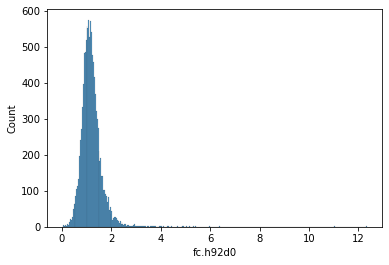

In [117]:
sns.histplot(data=gene_delta_te, x="fc.h92d0")
plt.show()
gene_delta_te_changed = gene_delta_te.loc[np.abs(np.log2(gene_delta_te['fc.h92d0']))>=np.log2(1.5)]
gene_delta_te_changed = gene_delta_te_changed.loc[gene_delta_te_changed.index.isin(wide_reac_df_10nt.index.get_level_values('gene').unique())]
#gene_delta_te_changed

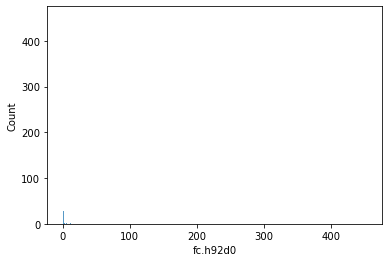

In [150]:
sns.histplot(data=gene_delta_decay, x="fc.h92d0")
plt.show()
gene_delta_decay_changed = gene_delta_decay.loc[np.abs(np.log2(gene_delta_decay['fc.h92d0']))>=np.log2(1.5)]
gene_delta_decay_changed = gene_delta_decay_changed.loc[gene_delta_decay_changed.index.isin(wide_reac_df_10nt.index.get_level_values('gene').unique())]

In [96]:
gene_delta_te = gene_delta_te.loc[gene_delta_te['fc.h92d0'].notna()]
gene_delta_te['zscore.fc.h92d0'] = stats.zscore(gene_delta_te['fc.h92d0'])
gene_delta_te_changed = gene_delta_te.loc[np.abs(gene_delta_te['zscore.fc.h92d0'])>=1.65]
gene_delta_te_changed = gene_delta_te_changed.loc[gene_delta_te_changed.index.isin(wide_reac_df_10nt.index.get_level_values('gene').unique())]
print (gene_delta_te.loc['RPL41'])
gene_delta_te_changed

stage
h9                 1.361468
day0               2.318440
day1               1.445806
day7               1.644712
fc.h92d0           1.702897
zscore.fc.h92d0    1.175036
Name: RPL41, dtype: float64


stage,h9,day0,day1,day7,fc.h92d0,zscore.fc.h92d0
gene,,,,,,
ARF6,0.709044,1.439392,1.421631,1.475016,2.030047,1.935054
C4orf48,1.138353,2.676844,2.733049,2.555751,2.351506,2.681848
CALM2,1.664485,6.102951,5.419417,6.031294,3.666570,5.736934
CCDC85B,0.336356,0.643315,0.592036,0.709872,1.912605,1.662218
DPY30,0.518325,1.118281,0.948289,1.046950,2.157488,2.231117
...,...,...,...,...,...,...
RPS3A,1.408792,0.578441,0.456600,0.339923,0.410594,-1.827172
RPS4X,0.968526,0.348779,0.299063,0.288598,0.360114,-1.944445
RPS6,0.837504,0.363296,0.382693,0.370227,0.433783,-1.773299


In [98]:
gene_delta_decay = gene_delta_decay.loc[gene_delta_decay['fc.h92d0'].notna()]
gene_delta_decay['zscore.fc.h92d0'] = stats.zscore(gene_delta_decay['fc.h92d0'])
gene_delta_decay_changed = gene_delta_decay.loc[np.abs(gene_delta_decay['zscore.fc.h92d0'])>=1.65]
gene_delta_decay_changed = gene_delta_decay_changed.loc[gene_delta_decay_changed.index.isin(wide_reac_df_10nt.index.get_level_values('gene').unique())]
#print (gene_delta_decay.loc['RPL41'])
gene_delta_decay_changed

stage,h9,day0,day1,day7,fc.h92d0,zscore.fc.h92d0
gene,,,,,,


0.8490606045155092 0.05005506990993583 0.8804254807816605 0.0


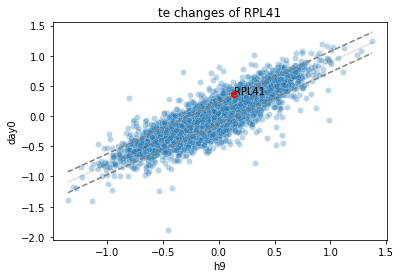

In [25]:
local_gene_delta_te = pd.DataFrame(np.log10(gene_delta_te), index=gene_delta_te.index, columns=gene_delta_te.columns).dropna()

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=local_gene_delta_te, x="h9", y="day0", ax=ax, alpha=0.3)
outliers = plot_confidence_intervals(local_gene_delta_te,  ax, colx="h9", coly='day0')
outliers
#for gene, row in outliers[0].iterrows():
#    x = row['h9']
#    y = row['day0']
#    ax.text(x,y,gene)
pum2_row = local_gene_delta_te.loc['RPL41']
x = pum2_row['h9']
y = pum2_row['day0']
ax.scatter(x,y, color="red")
ax.text(x,y,"RPL41")
plt.title('te changes of RPL41')
plt.show()

#### 5.2.2 check reac differences

In [27]:
## different reac btw pum2 control and OE/KD
def diff_reac_anova(row, level, g1, g2):
    ck_reac= row.xs(g1, level=level)
    tr_reac= row.xs(g2, level=level)
    if (ck_reac.dropna().size < 5) or (tr_reac.dropna().size < 5):
        return np.nan, np.nan, np.nan, np.nan
    else:
        s, p = stats.ttest_ind(ck_reac.dropna(), tr_reac.dropna())
        ck_avg_reac = ck_reac.mean()
        tr_avg_reac = tr_reac.mean()
        fc = tr_avg_reac / ck_avg_reac
        return ck_avg_reac, tr_avg_reac, fc, p
    
def add_annot_titles(diff_df, g1, g2, t):
    diff_df.columns = ['{}.avg_{}'.format(g1, t),'{}.avg_{}'.format(g2, t),'fc','pval']
    diff_df['log2fc'] = np.log2(diff_df['fc'])
    diff_df['-log10pval'] = -1*np.log10(diff_df['pval'])
    diff_df =  diff_df.loc[~diff_df['pval'].isnull()]
    rej, adjusted_p, sidak, cbonf = multitest.multipletests(diff_df['pval'], alpha=0.01, method="fdr_bh")
    diff_df['fdr'] = adjusted_p
    diff_df['-log10fdr'] = -1*np.log10(diff_df['fdr'])
    return diff_df

def calculated_diff_reac(crude_reac, level="stage", g1="h9", g2='day0', t="crude_reac"):
    h9_crude_reac = crude_reac.xs(g1, level=level, axis=1, drop_level=False)
    day0_crude_reac = crude_reac.xs(g2, level=level, axis=1, drop_level=False)
    h9_imputed_reac = imputation_of_qnorm(h9_crude_reac)
    day0_imputed_reac = imputation_of_qnorm(day0_crude_reac)
    crude_reac = pd.concat([h9_crude_reac, day0_crude_reac], axis=1, join="inner")
    imputed_reac = pd.concat([h9_imputed_reac, day0_imputed_reac], axis=1, join="inner")
    diff_crude_reac = crude_reac.apply(diff_reac_anova, args=(level, g1, g2), axis=1, result_type="expand")
    diff_imputed_reac = imputed_reac.apply(diff_reac_anova, args=(level, g1, g2), axis=1, result_type="expand")
    diff_crude_reac = add_annot_titles(diff_crude_reac, g1, g2, '{}'.format(t))
    diff_imputed_reac = add_annot_titles(diff_imputed_reac, g1, g2, 'imputed_{}'.format(t))
    return crude_reac, imputed_reac, diff_crude_reac, diff_imputed_reac

def calculated_diff_reac_to_diff_frame(crude_reac, level="stage", g1="h9", g2='day0', t="crude_reac"):
    h9_crude_reac = crude_reac.xs(g1, level=level, axis=1, drop_level=False)
    day0_crude_reac = crude_reac.xs(g2, level=level, axis=1, drop_level=False)
    print (h9_crude_reac.index.size, day0_crude_reac.index.size)
    crude_reac = pd.concat([h9_crude_reac, day0_crude_reac], axis=1, join="inner")
    diff_crude_reac = crude_reac.apply(diff_reac_anova, args=(level, g1, g2), axis=1, result_type="expand")
    diff_crude_reac = add_annot_titles(diff_crude_reac, g1, g2, '{}'.format(t))
    return diff_crude_reac

In [111]:
wide_reac_df_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
wide_reac_df_10nt
diff_h92d0_reac = calculated_diff_reac_to_diff_frame(wide_reac_df_10nt, level="stage", g1="h9", g2='day0', t="crude_reac")
# diff_h92d0_reac = diff_h92d0_reac.loc[diff_h92d0_reac['fdr']<0.05]

56080 56080


#### 5.2.3 overlap of reac differences and te differences
    1) the different reactivity was identified using ttest between h9 and day0 single-cell shapemap reactivity in 10-nt wins
    2) the different TE/Decay was identified as higher then 1.5 times fold-changes btw h9 vs day0

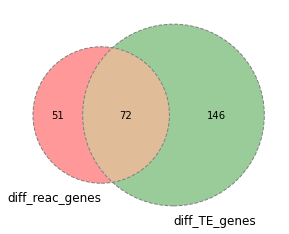

In [148]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn2_circles, venn3_circles

diffreac_genes = set(diff_h92d0_reac.loc[diff_h92d0_reac['fdr']<0.05].index.get_level_values('gene').unique())
diffte_genes = set(gene_delta_te_changed.index.unique())

venn2([diffreac_genes, diffte_genes], ['diff_reac_genes', 'diff_TE_genes'])
venn2_circles([diffreac_genes, diffte_genes], linestyle='dashed', linewidth=1, color="grey")
plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/overlap.diffreac_vs_diffTE.h9_to_day0.by_foldchange.pdf")
plt.show()

diffreac_to_diffte_df = pd.DataFrame([list(set(list(diffreac_genes)+list(diffte_genes)))], index=['gene']).T
diffreac_to_diffte_df['diff.reac'] = np.nan
diffreac_to_diffte_df.loc[diffreac_to_diffte_df['gene'].isin(diffreac_genes),'diff.reac'] = True
diffreac_to_diffte_df['diff.te'] = np.nan
diffreac_to_diffte_df.loc[diffreac_to_diffte_df['gene'].isin(diffte_genes),'diff.te'] = True
#diffreac_to_diffte_df.loc[diffreac_to_diffte_df[['diff.reac','diff.te']].sum(axis=1)==2]
diffreac_to_diffte_df.to_csv("../Current_Data/08.TE_&_Decay/overlap.diffreac_vs_diffTE.h9_to_day0.by_foldchange.csv")

123 301


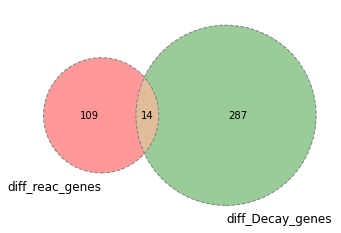

In [155]:
diffreac_genes = set(diff_h92d0_reac.loc[diff_h92d0_reac['fdr']<0.05].index.get_level_values('gene').unique())
diffdecay_genes = set(gene_delta_decay_changed.index.unique())
print (len(diffreac_genes), len(diffdecay_genes))

venn2([diffreac_genes, diffdecay_genes], ['diff_reac_genes', 'diff_Decay_genes'])
venn2_circles([diffreac_genes, diffdecay_genes], linestyle='dashed', linewidth=1, color="grey")
plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/overlap.diffreac_vs_diffDecay.h9_to_day0.by_foldchange.pdf")
plt.show()

diffreac_to_diffdecay_df = pd.DataFrame([list(set(list(diffreac_genes) + list(diffdecay_genes)))], index=['gene']).T
diffreac_to_diffdecay_df['diff.reac'] = np.nan
diffreac_to_diffdecay_df.loc[diffreac_to_diffdecay_df['gene'].isin(diffreac_genes),'diff.reac'] = True
diffreac_to_diffdecay_df['diff.decay'] = np.nan
diffreac_to_diffdecay_df.loc[diffreac_to_diffdecay_df['gene'].isin(diffdecay_genes),'diff.decay'] = True

diffreac_to_diffdecay_df.to_csv("../Current_Data/08.TE_&_Decay/overlap.diffreac_vs_diffDecay.h9_to_day0.by_foldchange.csv")

In [157]:
diffreac_to_diffdecay_df.loc[diffreac_to_diffdecay_df[['diff.reac','diff.decay']].sum(axis=1)==2]

,gene,diff.reac,diff.decay
39,TUBB,True,True
89,RPS7,True,True
110,TUBB2B,True,True
116,CNN3,True,True
127,MT-ND4,True,True
274,RPL15,True,True
292,UQCR11,True,True
295,RPL18,True,True
299,MT-CO2,True,True
309,RPL19,True,True


## 6. PUM2 OE/KD

### 6.1 reac & diff_reac in PUM2 OE/KD

In [31]:
pum2oe_reac_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/pum2OE.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
pum2kd_reac_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/pum2KD.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])

In [32]:
pum2_oe_reac_diff = pd.read_hdf("../Current_Data/09.Different_Reac/pum2_oe_reac_diff.hd5", key="df")
pum2_kd_reac_diff = pd.read_hdf("../Current_Data/09.Different_Reac/pum2_kd_reac_diff.hd5", key="df")

pum2_oe_reac_diff = pum2_oe_reac_diff.dropna(how="all")
pum2_kd_reac_diff = pum2_kd_reac_diff.dropna(how="all")

pum2_oe_reac_diff['fdr'] = multitest.multipletests(pum2_oe_reac_diff['pval'], method='fdr_bh')[1]
pum2_kd_reac_diff['fdr'] = multitest.multipletests(pum2_kd_reac_diff['pval'], method='fdr_bh')[1]


pum2_oe_reac_diff['diff_reac'] = pum2_oe_reac_diff['pum2'] - pum2_oe_reac_diff['control']
pum2_kd_reac_diff['diff_reac'] = pum2_kd_reac_diff['pum2'] - pum2_kd_reac_diff['control']

In [71]:
# pum2_oe_reac_diff['control.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['control'], [0.0,0.25,0.5,0.75,1.0], [1,2,3,4])
# pum2_oe_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['pum2'], [0.0,0.25,0.5,0.75,1.0], [1,2,3,4])
# pum2_oe_reac_diff
# pum2_kd_reac_diff['control.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['control'], [0.0,0.25,0.5,0.75,1.0], [1,2,3,4])
# pum2_kd_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['pum2'], [0.0,0.25,0.5,0.75,1.0], [1,2,3,4])
# pum2_kd_reac_diff

pum2_oe_reac_diff['control.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['control'], [0.0,0.33,0.66,1.0], ["double","mediate","single"])
pum2_oe_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['pum2'], [0.0,0.33,0.66,1.0], ["double","mediate","single"])
pum2_oe_reac_diff
pum2_kd_reac_diff['control.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['control'], [0.0,0.33,0.66,1.0], ["double","mediate","single"])
pum2_kd_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['pum2'], [0.0,0.33,0.66,1.0], ["double","mediate","single"])
pum2_kd_reac_diff


#pum2_oe_reac_diff['control.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['control'], [0.0,0.5,1.0], ["double","single"])
#pum2_oe_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['pum2'], [0.0,0.5,1.0], ["double","single"])
#pum2_oe_reac_diff
#pum2_kd_reac_diff['control.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['control'], [0.0,0.5,1.0], ["double","single"])
#pum2_kd_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['pum2'], [0.0,0.5,1.0], ["double","single"])
#pum2_kd_reac_diff

pval  foldchange   control      pum2       fdr  \
gene        pos                                                            
AAAS        1130  5.503058e-01    0.436707  0.032800  0.014324  0.795901   
            1140  2.408333e-01   -1.471774 -0.005222  0.007686  0.632632   
            1150  2.821451e-01   -4.170986 -0.006005  0.025046  0.658468   
            1160  1.976573e-01   -0.428742 -0.013334  0.005717  0.600005   
            1170  8.393084e-01    1.267134 -0.005243 -0.006643  0.935088   
...                        ...         ...       ...       ...       ...   
human_small 1820  2.219760e-07   -0.102006  0.013825 -0.001410  0.000160   
            1830  3.526259e-03    0.324351  0.013796  0.004475  0.096012   
            1840  4.248291e-01    1.370727  0.004106  0.005629  0.732246   
            1850  2.693062e-01    0.678199  0.014457  0.009805  0.651216   
            1860  2.326853e-07    3.233101 -0.014680 -0.047463  0.000163   

                  diff_reac control.reac.qtl pum2.reac.qtl  
gene        pos                                             
AAAS        1130  -0.018476           single        single  
            1140   0.012909           double        single  
            1150   0.031051           double        single  
            1160   0.019050           double       mediate  
            1170  -0.001401           double        double  
...                     ...              ...           ...  
human_small 1820  -0.015235           single        double  
            1830  -0.009321           single       mediate  
            1840   0.001522          mediate       mediate  
            1850  -0.004652           single        single  
            1860  -0.032783           double        double  

[191363 rows x 8 columns]

In [10]:
#sns.clustermap(data=pum2oe_reac_10nt.loc[pum2_oe_reac_diff.loc[pum2_oe_reac_diff['fdr']<0.01].index].fillna(0), cmap="coolwarm", z_score=0)
pum2_oe_reac_diff

pval  foldchange   control      pum2       fdr  \
gene        pos                                                        
A1BG        1380  0.909062    1.284080  0.014852  0.019071  0.966370   
            1390  0.007949   -0.321463  0.014090 -0.004529  0.174002   
            1400  0.242468   -6.263320 -0.002489  0.015588  0.661777   
            1410  0.152949    0.404555  0.015124  0.006119  0.591019   
            1420  0.148173    0.091131  0.010686  0.000974  0.585051   
...                    ...         ...       ...       ...       ...   
human_small 1820  0.335384    0.787101  0.004029  0.003171  0.710280   
            1830  0.449824    0.802486  0.004717  0.003786  0.760958   
            1840  0.705520    1.138725  0.002682  0.003054  0.879424   
            1850  0.755432    1.050344  0.011932  0.012532  0.901517   
            1860  0.059653    1.387596 -0.018425 -0.025567  0.438911   

                  diff_reac  
gene        pos              
A1BG        1380   0.004219  
            1390  -0.018620  
            1400   0.018077  
            1410  -0.009006  
            1420  -0.009712  
...                     ...  
human_small 1820  -0.000858  
            1830  -0.000932  
            1840   0.000372  
            1850   0.000601  
            1860  -0.007142  

[189918 rows x 6 columns]

### 6.2 Rsq in PUM2 OE/KD

In [50]:
pum2_oe_rsq = load_large_dataFrame("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_oe_rsq.csv", index_col=[0,1])
pum2_oe_rsq = pum2_oe_rsq.reset_index().pivot(index=['gene','pos'], columns=['stage'], values="rsq")
pum2_oe_rsq['diff_rsq'] = pum2_oe_rsq['pum2'] - pum2_oe_rsq['control']

pum2_kd_rsq = load_large_dataFrame("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_kd_rsq.csv", index_col=[0,1])
pum2_kd_rsq = pum2_kd_rsq.reset_index().pivot(index=['gene','pos'], columns=['stage'], values="rsq")
pum2_kd_rsq['diff_rsq'] = pum2_kd_rsq['pum2'] - pum2_kd_rsq['control']

In [33]:
# pum2_oe_rsq['control.rsq.qtl'] = pd.qcut(pum2_oe_rsq['control'], [0.0,0.25,0.5,0.75,1.0],["hetero","2","3","homo"])
# pum2_oe_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_oe_rsq['pum2'], [0.0,0.25,0.5,0.75,1.0],["hetero","2","3","homo"])
# pum2_kd_rsq['control.rsq.qtl'] = pd.qcut(pum2_kd_rsq['control'], [0.0,0.25,0.5,0.75,1.0],["hetero","2","3","homo"])
# pum2_kd_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_kd_rsq['pum2'], [0.0,0.25,0.5,0.75,1.0],["hetero","2","3","homo"])

pum2_oe_rsq['control.rsq.qtl'] = pd.qcut(pum2_oe_rsq['control'], [0.0,0.33,0.66,1.0],["hetero","mediate", "homo"])
pum2_oe_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_oe_rsq['pum2'], [0.0,0.33,0.66,1.0],["hetero","mediate", "homo"])
pum2_kd_rsq['control.rsq.qtl'] = pd.qcut(pum2_kd_rsq['control'], [0.0,0.33,0.66,1.0],["hetero","mediate", "homo"])
pum2_kd_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_kd_rsq['pum2'], [0.0,0.33,0.66,1.0],["hetero","mediate", "homo"])

# pum2_oe_rsq['control.rsq.qtl'] = pd.qcut(pum2_oe_rsq['control'], [0.0,0.5,1.0],["hetero","homo"])
# pum2_oe_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_oe_rsq['pum2'], [0.0,0.5,1.0],["hetero","homo"])
# pum2_kd_rsq['control.rsq.qtl'] = pd.qcut(pum2_kd_rsq['control'], [0.0,0.5,1.0],["hetero","homo"])
# pum2_kd_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_kd_rsq['pum2'], [0.0,0.5,1.0],["hetero","homo"])

pum2_oe_rsq

stage              control      pum2  diff_rsq control.rsq.qtl pum2.rsq.qtl
gene        pos                                                            
AAMP        1210       NaN  0.095610       NaN             NaN       hetero
            1220       NaN  0.814811       NaN             NaN         homo
            1230       NaN  0.860745       NaN             NaN         homo
            1240       NaN  0.871993       NaN             NaN         homo
            1250       NaN  0.917536       NaN             NaN         homo
...                    ...       ...       ...             ...          ...
human_small 1820  0.129918  0.016194 -0.113724          hetero       hetero
            1830  0.271643  0.005106 -0.266538          hetero       hetero
            1840  0.256510  0.023700 -0.232810          hetero       hetero
            1850  0.389578  0.069644 -0.319935         mediate       hetero
            1860  0.309841  0.193940 -0.115902          hetero       hetero

[72654 rows x 5 columns]

### 6.3 Reac2Rsq

In [34]:
pum2_oe_reac2rsq = pd.concat([pum2_oe_reac_diff[['diff_reac','control.reac.qtl','pum2.reac.qtl']], pum2_oe_rsq[['diff_rsq','control.rsq.qtl','pum2.rsq.qtl']]], axis=1)
pum2_oe_reac2rsq = pum2_oe_reac2rsq.dropna()
pum2_oe_reac2rsq

diff_reac control.reac.qtl pum2.reac.qtl  diff_rsq  \
gene        pos                                                        
AC005329.1  920   -0.007561           single       mediate  0.511528   
            930    0.010618           double       mediate  0.261471   
            940   -0.013324           single        double  0.668996   
            950    0.000051          mediate       mediate  0.237341   
            960   -0.012108          mediate        double  0.248778   
...                     ...              ...           ...       ...   
human_small 1820  -0.000858          mediate       mediate -0.113724   
            1830  -0.000932          mediate       mediate -0.266538   
            1840   0.000372          mediate       mediate -0.232810   
            1850   0.000601           single        single -0.319935   
            1860  -0.007142           double        double -0.115902   

                 control.rsq.qtl pum2.rsq.qtl  
gene        pos                                
AC005329.1  920           hetero         homo  
            930          mediate         homo  
            940           hetero         homo  
            950             homo         homo  
            960             homo         homo  
...                          ...          ...  
human_small 1820          hetero       hetero  
            1830          hetero       hetero  
            1840          hetero       hetero  
            1850         mediate       hetero  
            1860          hetero       hetero  

[47885 rows x 6 columns]

### 6.4 RBP targets

In [66]:
pum2_targets = rbp_binding_wins.loc[rbp_binding_wins['rbp'].isin(["PUM2"])]
pum2_targets
#pum2_targets_oe_reac2rsq = pum2_oe_reac2rsq.loc[pum2_oe_reac2rsq.index.isin(pum2_targets.index)]
#pum2_targets_oe_reac2rsq

rbp rbp_with_conditions  cell target_ensembl_id
target pos                                                   
FOXJ3  4950  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4960  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4970  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4980  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4990  PUM2       PUM2_K562_IDR  K562   ENST00000372572
...           ...                 ...   ...               ...
BTK    2600  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2610  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2620  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2630  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2640  PUM2       PUM2_K562_IDR  K562   ENST00000621635

[34159 rows x 4 columns]

### 6.5 PUM2 motifs with/without eCLIP peaks

In [8]:
pum2_peaks = rbp_binding_wins.loc[rbp_binding_wins['rbp'].isin(["PUM2","PUM1"])]
pum2_peaks
pum2_motifs = rbp_binding_motifs.loc[rbp_binding_motifs['rbp'].isin(["PUM2","PUM1"])]
pum2_motifs['with_peak'] = False
pum2_motifs.loc[pum2_motifs.index.isin(pum2_peaks.index),'with_peak'] = True
pum2_motifs

motif_start  motif_end   rbp strand    score       p-value  \
gene     pos                                                                  
SAMMSON  930             934        945  PUM1      +  23.3287  5.960000e-08   
ZNF735   1460           1464       1475  PUM1      +  23.3287  5.960000e-08   
ZDHHC21  1510           1514       1525  PUM1      +  23.3287  5.960000e-08   
SAMSN1   2190           2194       2205  PUM1      +  23.3287  5.960000e-08   
LIFR-AS1 2250           2249       2260  PUM1      +  23.3287  5.960000e-08   
...                      ...        ...   ...    ...      ...           ...   
XACT     323700       323706     323712  PUM1      +  13.6084  6.100000e-05   
         324020       324022     324028  PUM1      +  13.6084  6.100000e-05   
         326260       326266     326272  PUM1      +  13.6084  6.100000e-05   
         327070       327069     327075  PUM1      +  13.6084  6.100000e-05   
         334470       334475     334481  PUM1      +  13.6084  6.100000e-05   

                 q-value   matched_seq  with_peak  
gene     pos                                       
SAMMSON  930       0.310  AATTGTACATAA      False  
ZNF735   1460      0.310  AATTGTACATAA      False  
ZDHHC21  1510      0.310  AATTGTACATAA      False  
SAMSN1   2190      0.310  AATTGTACATAA       True  
LIFR-AS1 2250      0.310  AATTGTACATAA      False  
...                  ...           ...        ...  
XACT     323700    0.758       TGTACAT      False  
         324020    0.758       TGTACAT      False  
         326260    0.758       TGTACAT      False  
         327070    0.758       TGTACAT      False  
         334470    0.758       TGTACAT      False  

[111621 rows x 9 columns]

In [37]:
pum2_oe_reac2rsq_and_binding = pd.concat([pum2_oe_reac2rsq, pum2_motifs[['with_peak']].reset_index().drop_duplicates().set_index(['gene','pos'])], axis=1, join="outer")
pum2_oe_reac2rsq_and_binding

diff_reac control.reac.qtl pum2.reac.qtl  diff_rsq  \
gene       pos                                                          
AC005329.1 920     -0.007561           single       mediate  0.511528   
           930      0.010618           double       mediate  0.261471   
           940     -0.013324           single        double  0.668996   
           950      0.000051          mediate       mediate  0.237341   
           960     -0.012108          mediate        double  0.248778   
...                      ...              ...           ...       ...   
XACT       312930        NaN              NaN           NaN       NaN   
           323700        NaN              NaN           NaN       NaN   
           324020        NaN              NaN           NaN       NaN   
           326260        NaN              NaN           NaN       NaN   
           334470        NaN              NaN           NaN       NaN   

                  control.rsq.qtl pum2.rsq.qtl with_peak  
gene       pos                                            
AC005329.1 920             hetero         homo       NaN  
           930            mediate         homo       NaN  
           940             hetero         homo       NaN  
           950               homo         homo       NaN  
           960               homo         homo       NaN  
...                           ...          ...       ...  
XACT       312930             NaN          NaN     False  
           323700             NaN          NaN     False  
           324020             NaN          NaN     False  
           326260             NaN          NaN     False  
           334470             NaN          NaN     False  

[88713 rows x 7 columns]

In [38]:
## pum1/2 motifs with/without pum1/2 peaks in Single/Double or Hetero/Homo wins
out_df = pd.concat([
pum2_oe_reac2rsq_and_binding.loc[pum2_oe_reac2rsq_and_binding['control.reac.qtl']=="double",'with_peak'].value_counts(),
pum2_oe_reac2rsq_and_binding.loc[pum2_oe_reac2rsq_and_binding['control.reac.qtl']=="single",'with_peak'].value_counts(),
pum2_oe_reac2rsq_and_binding.loc[pum2_oe_reac2rsq_and_binding['control.rsq.qtl']=="hetero",'with_peak'].value_counts(),
pum2_oe_reac2rsq_and_binding.loc[pum2_oe_reac2rsq_and_binding['control.rsq.qtl']=="homo",'with_peak'].value_counts()], axis=1)
out_df.columns = ['reac.ds','reac.ss','rsq.hetero','rsq.homo']
out_df

,reac.ds,reac.ss,rsq.hetero,rsq.homo
False,24,35,39,33
True,3,20,24,1


In [39]:
concat_pct_lst = []
concat_count_lst = []

for reacqtl, subset in pum2_oe_reac2rsq_and_binding.groupby(['control.reac.qtl']):
    print (reacqtl)
    total_motif_numbers = subset.dropna().index.size
    total_motif_with_peak_numbers = subset['with_peak'].sum()
    
    pct_df = subset['with_peak'].value_counts(normalize=True).to_frame()
    pct_df.columns = pd.MultiIndex.from_tuples([(reacqtl, "all")], names=['reac.qtl','rsq.qtl'])
    count_df = subset['with_peak'].value_counts(normalize=False).to_frame()
    count_df.columns = pd.MultiIndex.from_tuples([(reacqtl, "all")], names=['reac.qtl','rsq.qtl'])
    concat_pct_lst.append(pct_df)
    concat_count_lst.append(count_df)
    print (total_motif_numbers, total_motif_with_peak_numbers)
    for rsqqtl, subsubset in subset.groupby(['control.rsq.qtl']):
        print (rsqqtl)
        pct_df = subsubset['with_peak'].value_counts(normalize=True).to_frame()
        count_df = subsubset['with_peak'].value_counts(normalize=False).to_frame()
        pct_df.columns = pd.MultiIndex.from_tuples([(reacqtl, rsqqtl)], names=['reac.qtl','rsq.qtl'])
        count_df.columns = pd.MultiIndex.from_tuples([(reacqtl, rsqqtl)], names=['reac.qtl','rsq.qtl'])
        concat_pct_lst.append(pct_df)
        concat_count_lst.append(count_df)
        
pct_df = pd.concat(concat_pct_lst, axis=1)
pct_df = pct_df.fillna(0)
pct_df.index.name = 'with_peak'
count_df = pd.concat(concat_count_lst, axis=1)
count_df = count_df.fillna(0)
count_df.index.name = 'with_peak'

double
27 3
hetero
mediate
homo
mediate
68 18
hetero
mediate
homo
single
55 20
hetero
mediate
homo


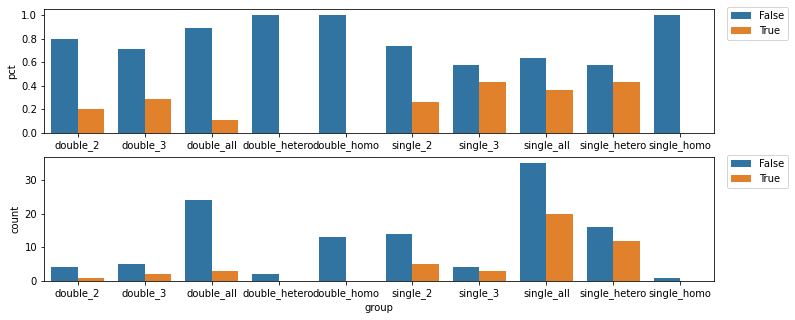

In [24]:
long_pct_df = pct_df.stack([0,1]).to_frame('pct').reset_index()
long_pct_df['group'] = long_pct_df['reac.qtl']+"_"+long_pct_df['rsq.qtl']

long_pct_df = long_pct_df.loc[long_pct_df['reac.qtl']!="mediate"]
#long_pct_df = long_pct_df.loc[long_pct_df['rsq.qtl']!="mediate"]

#t = pd.CategoricalDtype(categories=['single_hetero','single_mediate','single_homo', 'single_all',
#                                    ], ordered=True) ##'double_hetero','double_mediate','double_homo', 'double_all'
#long_pct_df['group'] = long_pct_df['group'].astype(t)


long_count_df = count_df.stack([0,1]).to_frame('count').reset_index()
long_count_df['group'] = long_count_df['reac.qtl']+"_"+long_count_df['rsq.qtl']

long_count_df = long_count_df.loc[long_count_df['reac.qtl']!="mediate"]
#long_count_df = long_count_df.loc[long_count_df['rsq.qtl']!="mediate"]

#t = pd.CategoricalDtype(categories=['single_hetero','single_mediate','single_homo', 'single_all',
#                                    ], ordered=True) ##'double_hetero','double_mediate','double_homo', 'double_all'
#long_count_df['group'] = long_count_df['group'].astype(t)

fig, axs = plt.subplots(2,1,figsize=(12,5))
ax = axs[0]
sns.barplot(data=long_pct_df, x="group", y="pct", hue="with_peak", ax=ax, dodge=True)
ax.legend(loc=[1.02,0.75])
ax = axs[1]
sns.barplot(data=long_count_df, x="group", y="count", hue="with_peak", ax=ax,)
ax.legend(loc=[1.02,0.75])
#plt.savefig("../Current_Figures/05.Consequence_of_heterogeneity/PUM2_motifs_with_eCLIP_peaks.association_to_heterogeneity.pdf")
plt.show()

In [45]:
pct_df

reac.qtl     double                                  single                   \
rsq.qtl         all    hetero   mediate      homo       all hetero   mediate   
with_peak                                                                      
False      0.862745  0.846154  0.666667  0.961538  0.656566   0.56  0.707317   
True       0.137255  0.153846  0.333333  0.038462  0.343434   0.44  0.292683   

reac.qtl        
rsq.qtl   homo  
with_peak       
False      1.0  
True       0.0

In [ ]:
concat_pct_lst = []
concat_count_lst = []

for reacqtl, subset in pum2_oe_reac2rsq_and_binding.groupby(['control.reac.qtl']):
    print (reacqtl, subset.dropna().index.size,)
    print (subset['with_peak'].value_counts(normalize=True))
    pct_df = subset['with_peak'].value_counts(normalize=True).to_frame()
    pct_df.columns = pd.MultiIndex.from_tuples([(reacqtl, "all")], names=['reac.qtl','rsq.qtl'])
    count_df = subset['with_peak'].value_counts(normalize=False).to_frame()
    count_df.columns = pd.MultiIndex.from_tuples([(reacqtl, "all")], names=['reac.qtl','rsq.qtl'])
    concat_pct_lst.append(pct_df)
    concat_count_lst.append(count_df)
    
for rsqqtl, subset in pum2_oe_reac2rsq_and_binding.groupby(['control.rsq.qtl']):
    print (rsqqtl, subset.dropna().index.size,)
    print (subset['with_peak'].value_counts(normalize=True))
    pct_df = subset['with_peak'].value_counts(normalize=True).to_frame()
    pct_df.columns = pd.MultiIndex.from_tuples([("all", rsqqtl)], names=['reac.qtl','rsq.qtl'])
    count_df = subset['with_peak'].value_counts(normalize=False).to_frame()
    count_df.columns = pd.MultiIndex.from_tuples([("all", rsqqtl)], names=['reac.qtl','rsq.qtl'])
    concat_pct_lst.append(pct_df)
    concat_count_lst.append(count_df)
    
for reacqtl, subset in pum2_oe_reac2rsq_and_binding.groupby(['control.reac.qtl']):
    print (reacqtl)
    for rsqqtl, subsubset in subset.groupby(['control.rsq.qtl']):
        print (rsqqtl)
        pct_df = subsubset['with_peak'].value_counts(normalize=True).to_frame()
        count_df = subsubset['with_peak'].value_counts(normalize=False).to_frame()
        pct_df.columns = pd.MultiIndex.from_tuples([(reacqtl, rsqqtl)], names=['reac.qtl','rsq.qtl'])
        count_df.columns = pd.MultiIndex.from_tuples([(reacqtl, rsqqtl)], names=['reac.qtl','rsq.qtl'])
        concat_pct_lst.append(pct_df)
        concat_count_lst.append(count_df)
        
pct_df = pd.concat(concat_pct_lst, axis=1)
pct_df = pct_df.fillna(0)
pct_df.index.name = 'with_peak'
count_df = pd.concat(concat_count_lst, axis=1)
count_df = count_df.fillna(0)
count_df.index.name = 'with_peak'

In [49]:
count_df

reac.qtl  double mediate single    all              double               \
rsq.qtl      all     all    all hetero mediate homo hetero mediate homo   
with_peak                                                                 
False         24      50     35     39      37   33    5.0       3   16   
True           3      18     20     24      16    1    0.0       2    1   

reac.qtl  mediate               single               
rsq.qtl    hetero mediate  homo hetero mediate homo  
with_peak                                            
False          15      19  16.0     19      15  1.0  
True           10       8   0.0     14       6  0.0

-14.529284365820363 0.023771878289102103 -0.40282487492716734 0.0


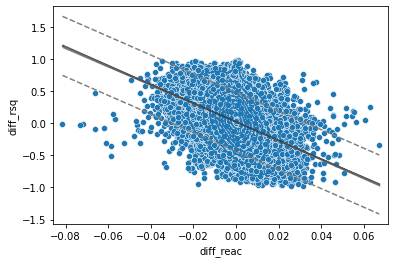

In [70]:

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=pum2_oe_reac2rsq.dropna(), x="diff_reac", y="diff_rsq", ax=ax)
sns.kdeplot(data=pum2_oe_reac2rsq.dropna(), x="diff_reac", y="diff_rsq", ax=ax)
outliers = plot_confidence_intervals(pum2_oe_reac2rsq.dropna(),  ax, colx="diff_reac", coly="diff_rsq")
#sns.scatterplot(data=outliers, x="diff_reac", y="diff_rsq", ax=ax, color="red")
plt.show()

-0.008817819265423984 0.00019348167150992466 -0.3306116104983943 3.668789142371827e-29


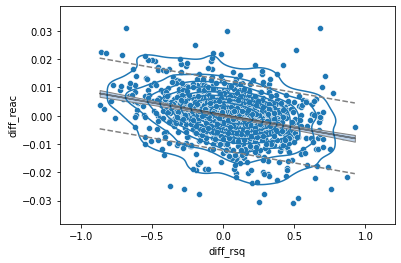

In [214]:

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=pum2_targets_oe_reac2rsq.dropna(), y="diff_reac", x="diff_rsq", ax=ax)
sns.kdeplot(data=pum2_targets_oe_reac2rsq.dropna(), y="diff_reac", x="diff_rsq", ax=ax)
outliers = plot_confidence_intervals(pum2_targets_oe_reac2rsq.dropna(),  ax, coly="diff_reac", colx="diff_rsq")
#sns.scatterplot(data=outliers, x="diff_reac", y="diff_rsq", ax=ax, color="red")
plt.show()

In [68]:
#sns.clustermap(pum2oe_reac_10nt.loc[pum2oe_reac_10nt.index.isin(outliers[0].index)].fillna(0), cmap="coolwarm", vmin=0, vmax=0.1, col_cluster=False)

In [48]:
pum2_oe_reac_diff_nochanged = pum2_oe_reac_diff.loc[(pum2_oe_reac_diff['pval']>0.05)&(np.abs(pum2_oe_reac_diff['foldchange'])<1)]
pum2_oe_reac_diff_changed = pum2_oe_reac_diff.loc[(pum2_oe_reac_diff['pval']<0.05)&(np.abs(pum2_oe_reac_diff['foldchange'])>=1)]

In [51]:
pum2_oe_rsq['zscore.diff_rsq'] = stats.zscore(pum2_oe_rsq['diff_rsq'], nan_policy="omit")
pum2_oe_rsq_changed = pum2_oe_rsq.loc[np.abs(pum2_oe_rsq['zscore.diff_rsq'])>=2]
pum2_oe_rsq_unchanged = pum2_oe_rsq.loc[np.abs(pum2_oe_rsq['zscore.diff_rsq'])<2]
pum2_oe_rsq_changed = pum2_oe_rsq_changed.loc[~pum2_oe_rsq_changed.index.get_level_values('gene').isin(["human_small","human_large"])]

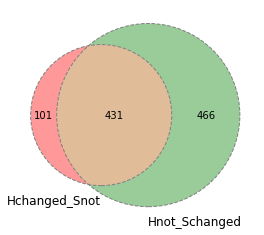

In [63]:
pum2_oe_Hchange_Sno = pum2_oe_rsq_changed.loc[pum2_oe_rsq_changed.index.isin(pum2_oe_reac_diff_nochanged.index)]
pum2_oe_Schange_Ho = pum2_oe_reac_diff_changed.loc[pum2_oe_reac_diff_changed.index.isin(pum2_oe_rsq_unchanged.index)]

pum2_oe_Hchange_Sno_genes = pum2_oe_Hchange_Sno.index.get_level_values('gene').unique()
pum2_oe_Schange_Ho_genes = pum2_oe_Schange_Ho.index.get_level_values('gene').unique()
pum2_oe_Hchange_Sno_genes = set(pum2_oe_Hchange_Sno_genes)
pum2_oe_Schange_Ho_genes = set(pum2_oe_Schange_Ho_genes)

from matplotlib_venn import venn2, venn2_circles, venn3, venn2_circles, venn3_circles

venn2([pum2_oe_Hchange_Sno_genes, pum2_oe_Schange_Ho_genes], ['Hchanged_Snot', 'Hnot_Schanged'])
venn2_circles([pum2_oe_Hchange_Sno_genes, pum2_oe_Schange_Ho_genes], linestyle='dashed', linewidth=1, color="grey")
#plt.savefig("../Current_Figures/04. Heterogeneity_and_Reactivity_at_RBP_binding_sites/PUM2OE/pum2oe.hchange_vs_schange.gene.venn.pdf")
plt.show()


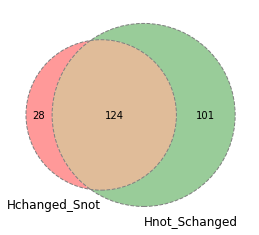

In [68]:
pum2_oe_Hchange_Sno = pum2_oe_rsq_changed.loc[pum2_oe_rsq_changed.index.isin(pum2_oe_reac_diff_nochanged.index)]
pum2_oe_Schange_Ho = pum2_oe_reac_diff_changed.loc[pum2_oe_reac_diff_changed.index.isin(pum2_oe_rsq_unchanged.index)]

pum2_oe_Hchange_Sno = pum2_oe_Hchange_Sno.loc[pum2_oe_Hchange_Sno.index.get_level_values('gene').isin(pum2_targets.index.get_level_values('target'))]
pum2_oe_Schange_Ho = pum2_oe_Schange_Ho.loc[pum2_oe_Schange_Ho.index.get_level_values('gene').isin(pum2_targets.index.get_level_values('target'))]

pum2_oe_Hchange_Sno_genes = pum2_oe_Hchange_Sno.index.get_level_values('gene').unique()
pum2_oe_Schange_Ho_genes = pum2_oe_Schange_Ho.index.get_level_values('gene').unique()
pum2_oe_Hchange_Sno_genes = set(pum2_oe_Hchange_Sno_genes)
pum2_oe_Schange_Ho_genes = set(pum2_oe_Schange_Ho_genes)

venn2([pum2_oe_Hchange_Sno_genes, pum2_oe_Schange_Ho_genes], ['Hchanged_Snot', 'Hnot_Schanged'])
venn2_circles([pum2_oe_Hchange_Sno_genes, pum2_oe_Schange_Ho_genes], linestyle='dashed', linewidth=1, color="grey")
plt.show()

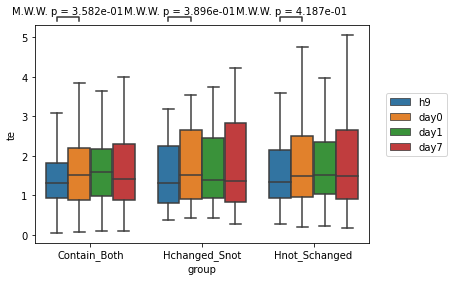

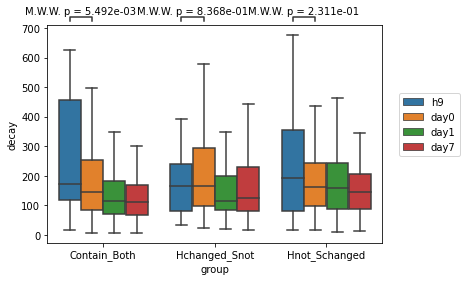

In [67]:
local_gene_te_and_decay = gene_te_and_decay.copy()
local_gene_te_and_decay['group'] = np.nan
local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(pum2_oe_Hchange_Sno_genes), 'group'] = "Hchanged_Snot"
local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(pum2_oe_Schange_Ho_genes), 'group'] = "Hnot_Schanged"
local_gene_te_and_decay.loc[(local_gene_te_and_decay.index.isin(pum2_oe_Schange_Ho_genes)&(local_gene_te_and_decay.index.isin(pum2_oe_Hchange_Sno_genes))), 'group'] = "Contain_Both"
local_gene_te_and_decay = local_gene_te_and_decay.loc[local_gene_te_and_decay['group'].notna()]
local_gene_te_and_decay = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(pum2_targets.index.get_level_values('target').unique())]

fig, ax = plt.subplots(1,1)
sns.boxplot(data=local_gene_te_and_decay, x="group", y="te", hue="stage", showfliers=False)
test_results = add_stat_annotation(ax, data=local_gene_te_and_decay, x="group", y="te", hue="stage",
                                           box_pairs=[(('Hnot_Schanged', 'h9'),('Hnot_Schanged', 'day0')),
                                                      (('Hchanged_Snot', 'h9'),('Hchanged_Snot', 'day0')),
                                                      (('Contain_Both', 'h9'),('Contain_Both', 'day0'))
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)

plt.legend(loc=[1.05, 0.4])
#plt.savefig("../Current_Figures/04. Heterogeneity_and_Reactivity_at_RBP_binding_sites/PUM2OE/pum2oe.hchange_vs_schange.gene.techange.pdf")
plt.show()

fig, ax = plt.subplots(1,1)
sns.boxplot(data=local_gene_te_and_decay, x="group", y="decay", hue="stage", showfliers=False)
test_results = add_stat_annotation(ax, data=local_gene_te_and_decay, x="group", y="decay", hue="stage",
                                           box_pairs=[(('Hnot_Schanged', 'h9'),('Hnot_Schanged', 'day0')),
                                                      (('Hchanged_Snot', 'h9'),('Hchanged_Snot', 'day0')),
                                                      (('Contain_Both', 'h9'),('Contain_Both', 'day0'))
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)

plt.legend(loc=[1.05, 0.4])
#plt.savefig("../Current_Figures/04. Heterogeneity_and_Reactivity_at_RBP_binding_sites/PUM2OE/pum2oe.hchange_vs_schange.gene.decaychange.pdf")
plt.show()

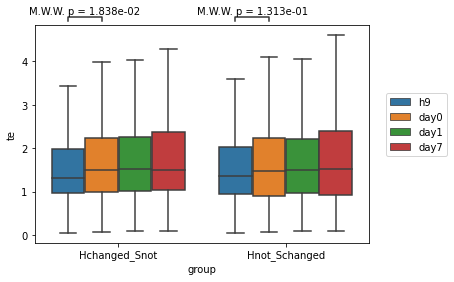

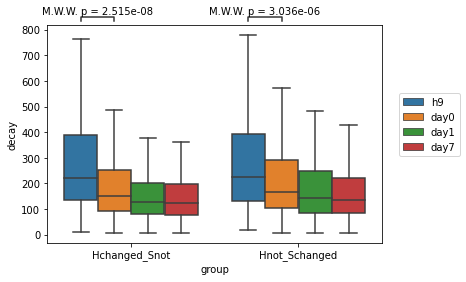

In [65]:
local_gene_te_and_decay = gene_te_and_decay.copy()
local_gene_te_and_decay['group'] = np.nan
a_local_gene_te_and_decay = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(pum2_oe_Hchange_Sno_genes)]
a_local_gene_te_and_decay['group'] = "Hchanged_Snot"
b_local_gene_te_and_decay = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(pum2_oe_Schange_Ho_genes)]
b_local_gene_te_and_decay['group'] = "Hnot_Schanged"

local_gene_te_and_decay = pd.concat([a_local_gene_te_and_decay, b_local_gene_te_and_decay])
local_gene_te_and_decay = local_gene_te_and_decay.loc[local_gene_te_and_decay['group'].notna()]
#local_gene_te_and_decay = local_gene_te_and_decay.loc[local_gene_te_and_decay.index.isin(pum2_targets.index.get_level_values('target').unique())]

fig, ax = plt.subplots(1,1)
sns.boxplot(data=local_gene_te_and_decay, x="group", y="te", hue="stage", showfliers=False)
test_results = add_stat_annotation(ax, data=local_gene_te_and_decay, x="group", y="te", hue="stage",
                                           box_pairs=[(('Hnot_Schanged', 'h9'),('Hnot_Schanged', 'day0')),
                                                      (('Hchanged_Snot', 'h9'),('Hchanged_Snot', 'day0')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)

plt.legend(loc=[1.05, 0.4])
plt.show()

fig, ax = plt.subplots(1,1)
sns.boxplot(data=local_gene_te_and_decay, x="group", y="decay", hue="stage", showfliers=False)
test_results = add_stat_annotation(ax, data=local_gene_te_and_decay, x="group", y="decay", hue="stage",
                                           box_pairs=[(('Hnot_Schanged', 'h9'),('Hnot_Schanged', 'day0')),
                                                      (('Hchanged_Snot', 'h9'),('Hchanged_Snot', 'day0')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)

plt.legend(loc=[1.05, 0.4])
plt.show()

### 6.6 TE/Decay in PUM2 targets (ss/ds, homo/hetero)

In [111]:
pum2_targets = rbp_binding_wins.loc[rbp_binding_wins['rbp'].isin(["PUM2","PUM1"])]
pum2_targets

rbp rbp_with_conditions  cell target_ensembl_id
target pos                                                   
PSMA7  500   PUM1       PUM1_K562_IDR  K562   ENST00000370873
       510   PUM1       PUM1_K562_IDR  K562   ENST00000370873
       520   PUM1       PUM1_K562_IDR  K562   ENST00000370873
       530   PUM1       PUM1_K562_IDR  K562   ENST00000370873
       540   PUM1       PUM1_K562_IDR  K562   ENST00000370873
...           ...                 ...   ...               ...
BTK    2600  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2610  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2620  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2630  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2640  PUM2       PUM2_K562_IDR  K562   ENST00000621635

[51876 rows x 4 columns]

In [184]:
pum2_oe_reac_diff['control.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['control'], [0.0,0.25,0.5,0.75,1.0], ["double","medium.2","medium.3","single"])
pum2_oe_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['pum2'], [0.0,0.25,0.5,0.75,1.0], ["double","medium.2","medium.3","single"])
pum2_oe_reac_diff
pum2_kd_reac_diff['control.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['control'], [0.0,0.25,0.5,0.75,1.0], ["double","medium.2","medium.3","single"])
pum2_kd_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['pum2'], [0.0,0.25,0.5,0.75,1.0], ["double","medium.2","medium.3","single"])

# pum2_oe_reac_diff['control.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['control'], [0.0,0.33,0.66,1.0], ["double","medium","single"])
# pum2_oe_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_oe_reac_diff['pum2'], [0.0,0.33,0.66,1.0], ["double","medium","single"])
# pum2_oe_reac_diff
# pum2_kd_reac_diff['control.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['control'], [0.0,0.33,0.66,1.0], ["double","medium","single"])
# pum2_kd_reac_diff['pum2.reac.qtl'] = pd.qcut(pum2_kd_reac_diff['pum2'], [0.0,0.33,0.66,1.0], ["double","medium","single"])

In [185]:
pum2_oe_rsq = load_large_dataFrame("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_oe_rsq.csv", index_col=[0,1])
pum2_oe_rsq = pum2_oe_rsq.reset_index().pivot(index=['gene','pos'], columns=['stage'], values="rsq")
pum2_oe_rsq['diff_rsq'] = pum2_oe_rsq['pum2'] - pum2_oe_rsq['control']
pum2_kd_rsq = load_large_dataFrame("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_kd_rsq.csv", index_col=[0,1])
pum2_kd_rsq = pum2_kd_rsq.reset_index().pivot(index=['gene','pos'], columns=['stage'], values="rsq")
pum2_kd_rsq['diff_rsq'] = pum2_kd_rsq['pum2'] - pum2_kd_rsq['control']

pum2_oe_rsq['control.rsq.qtl'] = pd.qcut(pum2_oe_rsq['control'], [0.0,0.25,0.5,0.75,1.0],["hetero","medium.2","medium.3", "homo"])
pum2_oe_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_oe_rsq['pum2'], [0.0,0.25,0.5,0.75,1.0],["hetero","medium.2","medium.3", "homo"])
pum2_kd_rsq['control.rsq.qtl'] = pd.qcut(pum2_kd_rsq['control'], [0.0,0.25,0.5,0.75,1.0],["hetero","medium.2","medium.3", "homo"])
pum2_kd_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_kd_rsq['pum2'], [0.0,0.25,0.5,0.75,1.0],["hetero","medium.2","medium.3", "homo"])

# pum2_oe_rsq['control.rsq.qtl'] = pd.qcut(pum2_oe_rsq['control'], [0.0,0.33,0.66,1.0],["hetero","medium", "homo"])
# pum2_oe_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_oe_rsq['pum2'], [0.0,0.33,0.66,1.0],["hetero","medium", "homo"])
# pum2_kd_rsq['control.rsq.qtl'] = pd.qcut(pum2_kd_rsq['control'], [0.0,0.33,0.66,1.0],["hetero","medium", "homo"])
# pum2_kd_rsq['pum2.rsq.qtl'] = pd.qcut(pum2_kd_rsq['pum2'], [0.0,0.33,0.66,1.0],["hetero","medium", "homo"])

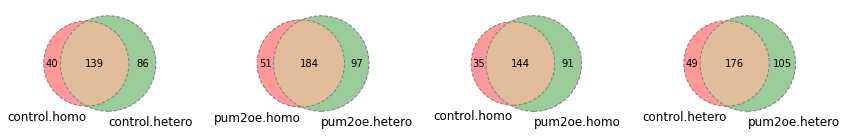

In [186]:
reac2rsq_df = pd.concat([pum2_oe_reac_diff[['control.reac.qtl','pum2.reac.qtl']], pum2_kd_rsq[['control.rsq.qtl','pum2.rsq.qtl']]], axis=1, join="inner")
pum2target_reac2rsq_df = reac2rsq_df.loc[reac2rsq_df.index.isin(pum2_targets.index)]
pum2target_reac2rsq_df

control_homo_target_genes = set(pum2target_reac2rsq_df.loc[pum2target_reac2rsq_df['control.rsq.qtl']=="homo"].index.get_level_values('gene').unique())
control_hetero_target_genes = set(pum2target_reac2rsq_df.loc[pum2target_reac2rsq_df['control.rsq.qtl']=="hetero"].index.get_level_values('gene').unique())

pum2oe_homo_target_genes = set(pum2target_reac2rsq_df.loc[pum2target_reac2rsq_df['pum2.rsq.qtl']=="homo"].index.get_level_values('gene').unique())
pum2oe_hetero_target_genes = set(pum2target_reac2rsq_df.loc[pum2target_reac2rsq_df['pum2.rsq.qtl']=="hetero"].index.get_level_values('gene').unique())


fig, axs = plt.subplots(1,4, figsize=(12,2))
ax=axs[0]
venn2([control_homo_target_genes, control_hetero_target_genes], ['control.homo', 'control.hetero'], ax=ax)
venn2_circles([control_homo_target_genes, control_hetero_target_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)

ax=axs[1]
venn2([pum2oe_homo_target_genes, pum2oe_hetero_target_genes], ['pum2oe.homo', 'pum2oe.hetero'], ax=ax)
venn2_circles([pum2oe_homo_target_genes, pum2oe_hetero_target_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)

ax=axs[2]
venn2([control_homo_target_genes, pum2oe_homo_target_genes], ['control.homo','pum2oe.homo'], ax=ax)
venn2_circles([control_homo_target_genes, pum2oe_homo_target_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)

ax=axs[3]
venn2([control_hetero_target_genes, pum2oe_hetero_target_genes], ['control.hetero','pum2oe.hetero'], ax=ax)
venn2_circles([control_hetero_target_genes, pum2oe_hetero_target_genes], linestyle='dashed', linewidth=1, color="grey", ax=ax)

plt.tight_layout()
plt.show()


In [181]:
gene_delta_te_and_decay = pd.concat([gene_delta_te[['fc.h92d0']], gene_delta_decay[['fc.h92d0']]], axis=1)
gene_delta_te_and_decay.columns = ['log2fc.te','log2fc.decay']
gene_delta_te_and_decay = gene_delta_te_and_decay.dropna()

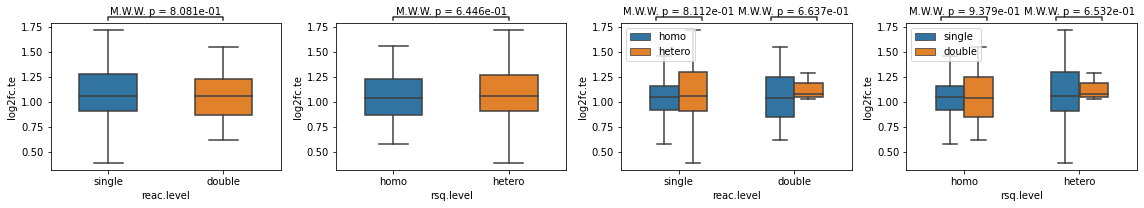

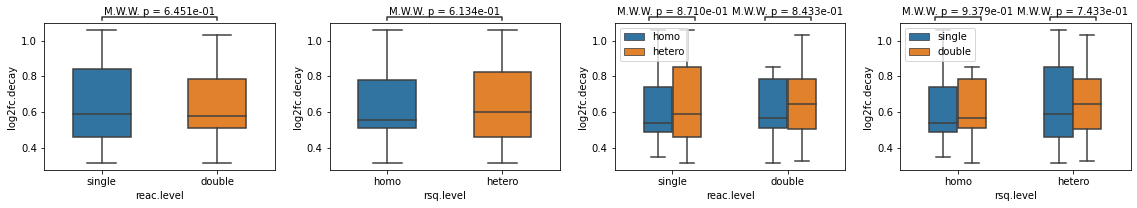

In [187]:
concat_lst = []
for rsq_level in ['homo','hetero']:
    for reac_level in ['single','double']:
        subset_genes  = pum2target_reac2rsq_df.loc[(pum2target_reac2rsq_df['control.reac.qtl']==reac_level)&(pum2target_reac2rsq_df['control.rsq.qtl']==rsq_level)].index.get_level_values('gene').unique()
        subset_conseq = gene_delta_te_and_decay.loc[gene_delta_te_and_decay.index.isin(subset_genes)]
        subset_conseq['reac.level'] = reac_level
        subset_conseq['rsq.level'] = rsq_level        
        concat_lst.append(subset_conseq)
all_conseq = pd.concat(concat_lst)
#all_conseq = all_conseq.loc[all_conseq['stage']=="h9"]

fig, axs = plt.subplots(1,4, figsize=(16,3))

sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.te", showfliers=False, ax=axs[0], width=.5)
test_results = add_stat_annotation(axs[0], data=all_conseq, x="reac.level", y="log2fc.te", 
                                           box_pairs=[('single','double')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.te",  showfliers=False, ax=axs[1], width=.5)
test_results = add_stat_annotation(axs[1], data=all_conseq, x="rsq.level", y="log2fc.te", 
                                           box_pairs=[('homo','hetero')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)

sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.te", hue="rsq.level", showfliers=False, ax=axs[2], width=.5)
test_results = add_stat_annotation(axs[2], data=all_conseq, x="reac.level", y="log2fc.te", hue="rsq.level",
                                           box_pairs=[(('single','homo'),('single','hetero')),
                                                      (('double','homo'),('double','hetero')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.te", hue="reac.level", showfliers=False, ax=axs[3], width=.5)
test_results = add_stat_annotation(axs[3], data=all_conseq, x="rsq.level", y="log2fc.te", hue="reac.level", 
                                           box_pairs=[(('homo','single'),('homo', 'double')),
                                                      (('hetero','single'),('hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
axs[2].legend(loc="upper left")
axs[3].legend(loc="upper left")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,4, figsize=(16,3))

sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.decay", showfliers=False, ax=axs[0], width=.5)
test_results = add_stat_annotation(axs[0], data=all_conseq, x="reac.level", y="log2fc.decay", 
                                           box_pairs=[('single','double')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.decay",  showfliers=False, ax=axs[1], width=.5)
test_results = add_stat_annotation(axs[1], data=all_conseq, x="rsq.level", y="log2fc.decay", 
                                           box_pairs=[('homo','hetero')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)


sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.decay", hue="rsq.level", showfliers=False, ax=axs[2], width=.5)
test_results = add_stat_annotation(axs[2], data=all_conseq, x="reac.level", y="log2fc.decay", hue="rsq.level",
                                           box_pairs=[(('single','homo'),('single','hetero')),
                                                      (('double','homo'),('double','hetero')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.decay", hue="reac.level", showfliers=False, ax=axs[3], width=.5)
test_results = add_stat_annotation(axs[3], data=all_conseq, x="rsq.level", y="log2fc.decay", hue="reac.level", 
                                           box_pairs=[(('homo','single'),('homo', 'double')),
                                                      (('hetero','single'),('hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
axs[2].legend(loc="upper left")
axs[3].legend(loc="upper left")
plt.tight_layout()
#plt.savefig("../Current_Figures/0")
plt.show()


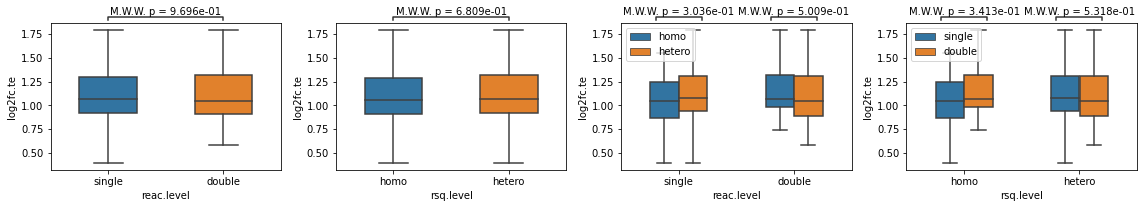

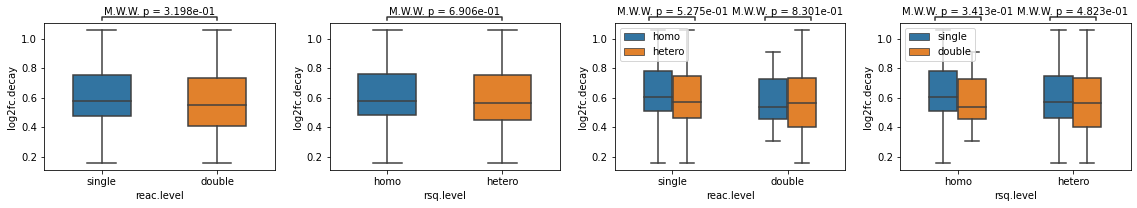

In [188]:
concat_lst = []
for rsq_level in ['homo','hetero']:
    for reac_level in ['single','double']:
        subset_genes  = pum2target_reac2rsq_df.loc[(pum2target_reac2rsq_df['pum2.reac.qtl']==reac_level)&(pum2target_reac2rsq_df['pum2.rsq.qtl']==rsq_level)].index.get_level_values('gene').unique()
        subset_conseq = gene_delta_te_and_decay.loc[gene_delta_te_and_decay.index.isin(subset_genes)]
        subset_conseq['reac.level'] = reac_level
        subset_conseq['rsq.level'] = rsq_level        
        concat_lst.append(subset_conseq)
all_conseq = pd.concat(concat_lst)
#all_conseq = all_conseq.loc[all_conseq['stage']=="h9"]

fig, axs = plt.subplots(1,4, figsize=(16,3))

sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.te", showfliers=False, ax=axs[0], width=.5)
test_results = add_stat_annotation(axs[0], data=all_conseq, x="reac.level", y="log2fc.te", 
                                           box_pairs=[('single','double')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.te",  showfliers=False, ax=axs[1], width=.5)
test_results = add_stat_annotation(axs[1], data=all_conseq, x="rsq.level", y="log2fc.te", 
                                           box_pairs=[('homo','hetero')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)

sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.te", hue="rsq.level", showfliers=False, ax=axs[2], width=.5)
test_results = add_stat_annotation(axs[2], data=all_conseq, x="reac.level", y="log2fc.te", hue="rsq.level",
                                           box_pairs=[(('single','homo'),('single','hetero')),
                                                      (('double','homo'),('double','hetero')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.te", hue="reac.level", showfliers=False, ax=axs[3], width=.5)
test_results = add_stat_annotation(axs[3], data=all_conseq, x="rsq.level", y="log2fc.te", hue="reac.level", 
                                           box_pairs=[(('homo','single'),('homo', 'double')),
                                                      (('hetero','single'),('hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
axs[2].legend(loc="upper left")
axs[3].legend(loc="upper left")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,4, figsize=(16,3))

sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.decay", showfliers=False, ax=axs[0], width=.5)
test_results = add_stat_annotation(axs[0], data=all_conseq, x="reac.level", y="log2fc.decay", 
                                           box_pairs=[('single','double')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.decay",  showfliers=False, ax=axs[1], width=.5)
test_results = add_stat_annotation(axs[1], data=all_conseq, x="rsq.level", y="log2fc.decay", 
                                           box_pairs=[('homo','hetero')
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)


sns.boxplot(data=all_conseq, x="reac.level", y="log2fc.decay", hue="rsq.level", showfliers=False, ax=axs[2], width=.5)
test_results = add_stat_annotation(axs[2], data=all_conseq, x="reac.level", y="log2fc.decay", hue="rsq.level",
                                           box_pairs=[(('single','homo'),('single','hetero')),
                                                      (('double','homo'),('double','hetero')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
sns.boxplot(data=all_conseq, x="rsq.level", y="log2fc.decay", hue="reac.level", showfliers=False, ax=axs[3], width=.5)
test_results = add_stat_annotation(axs[3], data=all_conseq, x="rsq.level", y="log2fc.decay", hue="reac.level", 
                                           box_pairs=[(('homo','single'),('homo', 'double')),
                                                      (('hetero','single'),('hetero', 'double')),
                                                      ],
                                           test='Mann-Whitney', text_format='full',
                                           loc='outside', verbose=0.2, 
                                           comparisons_correction=None,
                                           line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
axs[2].legend(loc="upper left")
axs[3].legend(loc="upper left")
plt.tight_layout()
#plt.savefig("../Current_Figures/0")
plt.show()


In [160]:
gene_te_and_decay

,stage,te,decay
gene,,,
A1BG,h9,1.355745,NaN
A1BG,day0,1.391350,NaN
A1BG,day1,1.765751,NaN
A1BG,day7,2.959838,NaN
A2M,day0,0.748374,NaN
...,...,...,...
ZSCAN26,h9,NaN,22.653038
ZSCAN26,day7,NaN,28.591805
snoU109,day0,NaN,38.381405


In [161]:
all_conseq.reset_index().groupby(['gene','stage',])

,stage,te,decay,reac.level,rsq.level
gene,,,,,
ARGLU1,h9,1.913230,NaN,single,homo
ARGLU1,day0,1.833902,NaN,single,homo
ARGLU1,day1,2.151120,NaN,single,homo
ARGLU1,day7,2.798489,NaN,single,homo
AURKAIP1,day0,1.784028,161.918969,single,homo
...,...,...,...,...,...
SNU13,day0,NaN,283.381087,double,hetero
SNU13,day1,NaN,250.708616,double,hetero
SNU13,day7,NaN,233.350045,double,hetero


## 7. RBP real binding propotion 

### 7.1 Loading Data

In [10]:
## the RBP binding wins in Eclip
rbp_binding_wins = load_large_dataFrame("../Current_Data/07.RBP_targets/clip.allPeak.ENCODE_genome2TransCoords.longestCDS.binding_wins.csv", 
                                        header=[0], index_col=[0,1])
rbp_binding_wins
## PUM2 binding Motifs
rbp_binding_motifs = load_large_dataFrame("../Current_Data/07.RBP_targets/fimo.RBP_motifs_on_ref.rbp.txt", header=[0], index_col=[0,1])
#rbp_binding_motifs

In [4]:
wide_reac_df_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
wide_reac_df_1nt = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
#wide_reac_df_10nt

In [5]:
long_rsq_df_10nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.10nt.stage.csv",  header=[0], index_col=[0,1])
long_rsq_df_10nt['rsq'] = np.power(long_rsq_df_10nt['r'],2)
wide_rsq_df_10nt = long_rsq_df_10nt.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
#wide_rsq_df_10nt

long_rsq_df_1nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.1nt.stage.csv",  header=[0], index_col=[0,1])
long_rsq_df_1nt['rsq'] = np.power(long_rsq_df_1nt['r'],2)
wide_rsq_df_1nt = long_rsq_df_1nt.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
#wide_rsq_df_1nt

### 7.2 Assign windows to Single/Double or Homo/Hetero

In [6]:
wide_avg_reac_df = wide_reac_df_10nt.groupby(level="stage", axis=1).mean()
wide_avg_reac_df = wide_avg_reac_df.loc[~wide_avg_reac_df['h9'].isna()]
wide_avg_reac_df['h9.reac.qtl'] = pd.qcut(wide_avg_reac_df['h9'], [0,0.33,0.66,1.0], ['ds','medium','ss'])

wide_rsq_df_10nt['h9.rsq.qtl'] = pd.qcut(wide_rsq_df_10nt['h9'], [0,0.33,0.66,1.0], ['Hetero','Medium','Homo'])
wide_rsq_df_10nt

wide_reac2rsq = pd.concat([wide_avg_reac_df[['h9.reac.qtl']], wide_rsq_df_10nt[['h9.rsq.qtl']]], axis=1)
wide_reac2rsq = wide_reac2rsq.dropna()
wide_reac2rsq

stage            h9.reac.qtl h9.rsq.qtl
gene        pos                        
AARS1       3160          ds     Hetero
            3170          ss       Homo
            3180      medium       Homo
            3190          ss       Homo
            3200          ds       Homo
...                      ...        ...
human_small 1820      medium     Hetero
            1830          ds     Medium
            1840          ds       Homo
            1850          ss       Homo
            1860          ds       Homo

[55440 rows x 2 columns]

### 7.3 RBP targets

PUM2


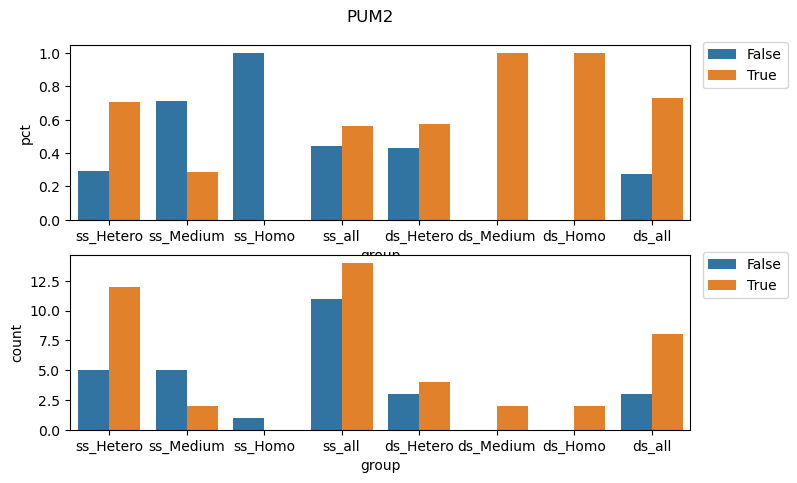

    with_peak reac.qtl rsq.qtl  count      group
0        True       ds  Hetero    4.0  ds_Hetero
1        True       ds    Homo    2.0    ds_Homo
2        True       ds  Medium    2.0  ds_Medium
3        True       ds     all    8.0     ds_all
8        True       ss  Hetero   12.0  ss_Hetero
9        True       ss    Homo    0.0    ss_Homo
10       True       ss  Medium    2.0  ss_Medium
11       True       ss     all   14.0     ss_all
12      False       ds  Hetero    3.0  ds_Hetero
13      False       ds    Homo    0.0    ds_Homo
14      False       ds  Medium    0.0  ds_Medium
15      False       ds     all    3.0     ds_all
20      False       ss  Hetero    5.0  ss_Hetero
21      False       ss    Homo    1.0    ss_Homo
22      False       ss  Medium    5.0  ss_Medium
23      False       ss     all   11.0     ss_all


In [8]:
#for rbp in rbp_binding_wins['rbp'].unique():
for rbp in ['PUM2']:

    
    rbp_peaks = rbp_binding_wins.loc[rbp_binding_wins['rbp'].isin([rbp])]
    rbp_peaks
    
    
    if rbp not in rbp_binding_motifs['rbp'].unique():
        #print ("skip {}".format(rbp))
        continue
    else:
        print (rbp)
        
        rbp_motifs = rbp_binding_motifs.loc[rbp_binding_motifs['rbp'].isin([rbp])]
        #if (rbp_peaks.index.size < 20) & (rbp_motifs.index.size < 20):
        #    continue
        rbp_motifs['with_peak'] = False
        rbp_motifs.loc[rbp_motifs.index.isin(rbp_peaks.index),'with_peak'] = True
        rbp_motifs
        
        
        ## the rbp targets in SHAPE-Map data
        rbp_reac2rsq_and_binding = pd.concat([wide_reac2rsq, rbp_motifs[['with_peak']].reset_index().drop_duplicates().set_index(['gene','pos'])], axis=1, join="outer")
        plot_pct(rbp_reac2rsq_and_binding, rbp)

In [9]:
for rbp in ['PUM2']:

    
    rbp_peaks = rbp_binding_wins.loc[rbp_binding_wins['rbp'].isin([rbp])]
    rbp_peaks
    
    
    if rbp not in rbp_binding_motifs['rbp'].unique():
        #print ("skip {}".format(rbp))
        continue
    else:
        print (rbp)
        
        rbp_motifs = rbp_binding_motifs.loc[rbp_binding_motifs['rbp'].isin([rbp])]
        #if (rbp_peaks.index.size < 20) & (rbp_motifs.index.size < 20):
        #    continue
        rbp_motifs['with_peak'] = False
        rbp_motifs.loc[rbp_motifs.index.isin(rbp_peaks.index),'with_peak'] = True
        rbp_motifs
        
        
        ## the rbp targets in SHAPE-Map data
        rbp_reac2rsq_and_binding = pd.concat([wide_reac2rsq, 
                                              rbp_motifs[['with_peak']].reset_index().drop_duplicates().set_index(['gene','pos'])], axis=1, join="outer")
        

PUM2


In [12]:
rbp_peaks

rbp rbp_with_conditions  cell target_ensembl_id
target pos                                                   
FOXJ3  4950  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4960  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4970  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4980  PUM2       PUM2_K562_IDR  K562   ENST00000372572
       4990  PUM2       PUM2_K562_IDR  K562   ENST00000372572
...           ...                 ...   ...               ...
BTK    2600  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2610  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2620  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2630  PUM2       PUM2_K562_IDR  K562   ENST00000621635
       2640  PUM2       PUM2_K562_IDR  K562   ENST00000621635

[34159 rows x 4 columns]

In [17]:
rbp_reac2rsq_and_binding_peaks = wide_reac2rsq.copy()
rbp_reac2rsq_and_binding_peaks['with_peak'] = False
rbp_reac2rsq_and_binding_peaks.loc[rbp_reac2rsq_and_binding_peaks.index.isin(rbp_peaks.index), "with_peak"] = True
rbp_reac2rsq_and_binding_peaks

stage            h9.reac.qtl h9.rsq.qtl  with_peak
gene        pos                                   
AARS1       3160          ds     Hetero      False
            3170          ss       Homo      False
            3180      medium       Homo      False
            3190          ss       Homo      False
            3200          ds       Homo      False
...                      ...        ...        ...
human_small 1820      medium     Hetero      False
            1830          ds     Medium      False
            1840          ds       Homo      False
            1850          ss       Homo      False
            1860          ds       Homo      False

[55440 rows x 3 columns]

<AxesSubplot:xlabel='h9.reac.qtl,h9.rsq.qtl'>

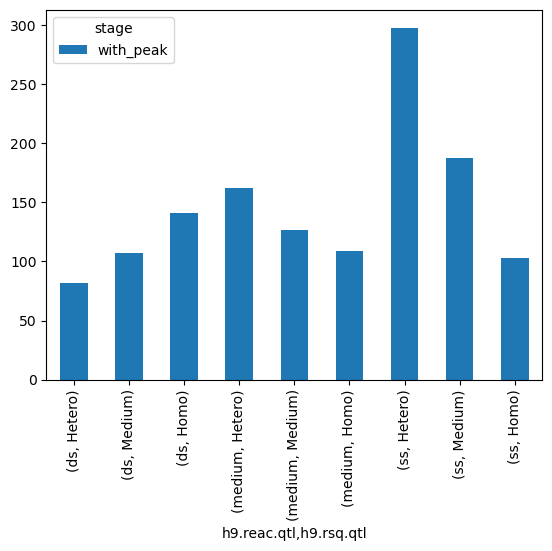

In [19]:
rbp_reac2rsq_and_binding_peaks.groupby(['h9.reac.qtl','h9.rsq.qtl']).sum().plot.bar()

In [20]:
rbp_reac2rsq_and_binding_peaks.groupby(['h9.reac.qtl','h9.rsq.qtl']).sum()

stage                   with_peak
h9.reac.qtl h9.rsq.qtl           
ds          Hetero             82
            Medium            107
            Homo              141
medium      Hetero            162
            Medium            127
            Homo              109
ss          Hetero            298
            Medium            188
            Homo              103

In [46]:
rbp_reac2rsq_and_binding = pd.concat([wide_reac2rsq, rbp_motifs[['with_peak']].reset_index().drop_duplicates().set_index(['gene','pos'])], axis=1, join="outer")
rbp_reac2rsq_and_binding.dropna()

out_df = pd.concat([
rbp_reac2rsq_and_binding.loc[rbp_reac2rsq_and_binding['h9.reac.qtl']=="ds",'with_peak'].value_counts(),
rbp_reac2rsq_and_binding.loc[rbp_reac2rsq_and_binding['h9.reac.qtl']=="ss",'with_peak'].value_counts(),
rbp_reac2rsq_and_binding.loc[rbp_reac2rsq_and_binding['h9.rsq.qtl']=="Hetero",'with_peak'].value_counts(),
rbp_reac2rsq_and_binding.loc[rbp_reac2rsq_and_binding['h9.rsq.qtl']=="Homo",'with_peak'].value_counts()], axis=1)
out_df.columns = ['reac.ds','reac.ss','rsq.hetero','rsq.homo']
out_df

,reac.ds,reac.ss,rsq.hetero,rsq.homo
False,90,123,113,77
True,13,15,12,10


In [45]:
#rbp_binding_motifs['rbp']
rbp_reac2rsq_and_binding.loc[(rbp_reac2rsq_and_binding['h9.reac.qtl']=='ds')&(rbp_reac2rsq_and_binding['with_peak']==True)]

h9.reac.qtl h9.rsq.qtl with_peak
gene    pos                                  
APEX1   1340          ds     Medium      True
        1350          ds     Medium      True
BRK1    380           ds       Homo      True
BSG     1350          ds       Homo      True
        1380          ds       Homo      True
CDK2AP1 1060          ds     Hetero      True
PSMB2   750           ds     Hetero      True
PTGES3  1720          ds     Medium      True
RANBP1  1000          ds       Homo      True
SET     1200          ds     Medium      True
SHMT2   1760          ds     Medium      True
TUBB    1600          ds     Medium      True
        2450          ds     Medium      True

### 7.4

In [7]:
 def plot_pct(rbp_reac2rsq_and_binding, rbp):
    concat_pct_lst = []
    concat_count_lst = []

    for reacqtl, subset in rbp_reac2rsq_and_binding.groupby(['h9.reac.qtl']):
        #print (reacqtl)
        total_motif_numbers = subset.dropna().index.size
        total_motif_with_peak_numbers = subset['with_peak'].sum()

        pct_df = subset['with_peak'].value_counts(normalize=True).to_frame()
        pct_df.columns = pd.MultiIndex.from_tuples([(reacqtl, "all")], names=['reac.qtl','rsq.qtl'])
        count_df = subset['with_peak'].value_counts(normalize=False).to_frame()
        count_df.columns = pd.MultiIndex.from_tuples([(reacqtl, "all")], names=['reac.qtl','rsq.qtl'])
        concat_pct_lst.append(pct_df)
        concat_count_lst.append(count_df)
        #print (total_motif_numbers, total_motif_with_peak_numbers)
        for rsqqtl, subsubset in subset.groupby(['h9.rsq.qtl']):
            #print (rsqqtl)
            pct_df = subsubset['with_peak'].value_counts(normalize=True).to_frame()
            count_df = subsubset['with_peak'].value_counts(normalize=False).to_frame()
            pct_df.columns = pd.MultiIndex.from_tuples([(reacqtl, rsqqtl)], names=['reac.qtl','rsq.qtl'])
            count_df.columns = pd.MultiIndex.from_tuples([(reacqtl, rsqqtl)], names=['reac.qtl','rsq.qtl'])
            concat_pct_lst.append(pct_df)
            concat_count_lst.append(count_df)

    pct_df = pd.concat(concat_pct_lst, axis=1)
    pct_df = pct_df.fillna(0)
    pct_df.index.name = 'with_peak'
    count_df = pd.concat(concat_count_lst, axis=1)
    count_df = count_df.fillna(0)
    count_df.index.name = 'with_peak'

    ##############################################################################


    long_pct_df = pct_df.stack([0,1]).to_frame('pct').reset_index()
    long_pct_df['group'] = long_pct_df['reac.qtl']+"_"+long_pct_df['rsq.qtl']
    long_pct_df = long_pct_df.loc[long_pct_df['reac.qtl']!="medium"]
    #long_pct_df = long_pct_df.loc[long_pct_df['rsq.qtl']!="mediate"]

    t = pd.CategoricalDtype(categories=['ss_Hetero','ss_Medium','ss_Homo','ss_all',
                                        'ds_Hetero','ds_Medium','ds_Homo','ds_all',
                                        ], ordered=True) ##'double_hetero','double_mediate','double_homo', 'double_all'
    long_pct_df['group'] = long_pct_df['group'].astype(t)


    long_count_df = count_df.stack([0,1]).to_frame('count').reset_index()
    long_count_df['group'] = long_count_df['reac.qtl']+"_"+long_count_df['rsq.qtl']
    long_count_df = long_count_df.loc[long_count_df['reac.qtl']!="medium"]
    #long_count_df = long_count_df.loc[long_count_df['rsq.qtl']!="mediate"]

    #t = pd.CategoricalDtype(categories=['single_hetero','single_mediate','single_homo', 'single_all',
    #                                    ], ordered=True) ##'double_hetero','double_mediate','double_homo', 'double_all'
    long_count_df['group'] = long_count_df['group'].astype(t)

    fig, axs = plt.subplots(2,1,figsize=(8,5))
    ax = axs[0]
    sns.barplot(data=long_pct_df, x="group", y="pct", hue="with_peak", ax=ax, dodge=True)
    ax.legend(loc=[1.02,0.75])
    ax = axs[1]
    sns.barplot(data=long_count_df, x="group", y="count", hue="with_peak", ax=ax,)
    ax.legend(loc=[1.02,0.75])
    #plt.savefig("../Current_Figures/05.Consequence_of_heterogeneity/PUM2_motifs_with_eCLIP_peaks.association_to_heterogeneity.pdf")
    plt.suptitle(rbp, y=0.95)
    plt.show()
    
    
    print (long_count_df)

## 8. RBP real binding in PUM2 target genes